In [ ]:
# this modifies the vae version but adding subject as conditions

In [1]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fix the random seeds for Python, NumPy, and PyTorch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
sub_cond_path = '../subject_info.xlsx'
base_nifti_folder = '../data_FC'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [4]:
# Load and preprocess
# load aal FC matrix
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, base_nifti_folder, mat_filename='conn_matrix.mat')
X_tensor = preprocess_for_torch(all_corr_data)

# One-hot encode subject ID as condition
subject_arr = np.array(all_subject_id).reshape(-1, 1)
subject_encoder = OneHotEncoder(sparse_output=False, drop=None)
subject_ohe = subject_encoder.fit_transform(subject_arr)  # shape: [n_samples, n_subjects]

subject_cond_tensor = torch.tensor(subject_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor, subject_cond_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # each batch has 32 samples

[WARN] File not found: ../data_FC/NODEAP_30/S3D2/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_44/S1D1/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_83/S3D1/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_87/D0/conn_matrix.mat
[WARN] File not found: ../data_FC/NODEAP_88/D0/conn_matrix.mat
Columns with NaN: 229 / 6670
Tensor shape after preprocessing: torch.Size([331, 6441])


In [5]:
X_tensor.shape

torch.Size([331, 6441])

In [6]:
subject_cond_tensor.shape

torch.Size([331, 48])

In [8]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
cond_dim = subject_cond_tensor.shape[1]
latent_dim = 10
model = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim).to(DEVICE)

NUM_EPOCH = 1000
LR = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 208.82it/s]


Epoch 1, Loss: 6530.0815, Recon: 6529.2319, KL: 0.8496

===== Epoch 2 =====


Epoch 2/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 213.73it/s]


Epoch 2, Loss: 6495.6771, Recon: 6493.1655, KL: 2.5116

===== Epoch 3 =====


Epoch 3/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 152.83it/s]


Epoch 3, Loss: 6462.3919, Recon: 6457.7104, KL: 4.6815

===== Epoch 4 =====


Epoch 4/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 180.95it/s]


Epoch 4, Loss: 6407.7880, Recon: 6398.3251, KL: 9.4629

===== Epoch 5 =====


Epoch 5/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 200.04it/s]


Epoch 5, Loss: 6311.5130, Recon: 6292.5095, KL: 19.0035

===== Epoch 6 =====


Epoch 6/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 207.27it/s]


Epoch 6, Loss: 6164.7535, Recon: 6134.7208, KL: 30.0327

===== Epoch 7 =====


Epoch 7/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 206.92it/s]


Epoch 7, Loss: 6005.4885, Recon: 5965.1147, KL: 40.3739

===== Epoch 8 =====


Epoch 8/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 206.55it/s]


Epoch 8, Loss: 5845.9584, Recon: 5797.7838, KL: 48.1746

===== Epoch 9 =====


Epoch 9/1000: 100%|████████████████████████████| 11/11 [00:00<00:00, 212.15it/s]


Epoch 9, Loss: 5703.7559, Recon: 5649.1021, KL: 54.6538

===== Epoch 10 =====


Epoch 10/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 199.84it/s]


Epoch 10, Loss: 5570.9755, Recon: 5511.0363, KL: 59.9391

===== Epoch 11 =====


Epoch 11/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 208.45it/s]


Epoch 11, Loss: 5455.2291, Recon: 5390.4724, KL: 64.7567

===== Epoch 12 =====


Epoch 12/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 220.87it/s]


Epoch 12, Loss: 5353.0642, Recon: 5284.8805, KL: 68.1837

===== Epoch 13 =====


Epoch 13/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 212.62it/s]


Epoch 13, Loss: 5259.1388, Recon: 5187.7572, KL: 71.3816

===== Epoch 14 =====


Epoch 14/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 219.87it/s]


Epoch 14, Loss: 5173.7904, Recon: 5099.2467, KL: 74.5437

===== Epoch 15 =====


Epoch 15/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 210.13it/s]


Epoch 15, Loss: 5096.0731, Recon: 5019.0771, KL: 76.9960

===== Epoch 16 =====


Epoch 16/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 214.81it/s]


Epoch 16, Loss: 5027.6106, Recon: 4948.8681, KL: 78.7426

===== Epoch 17 =====


Epoch 17/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 223.33it/s]


Epoch 17, Loss: 4960.6936, Recon: 4879.7069, KL: 80.9866

===== Epoch 18 =====


Epoch 18/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 205.74it/s]


Epoch 18, Loss: 4894.0057, Recon: 4809.9706, KL: 84.0351

===== Epoch 19 =====


Epoch 19/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 224.86it/s]


Epoch 19, Loss: 4832.3655, Recon: 4748.3259, KL: 84.0396

===== Epoch 20 =====


Epoch 20/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 205.17it/s]


Epoch 20, Loss: 4775.5067, Recon: 4688.7043, KL: 86.8024

===== Epoch 21 =====


Epoch 21/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 204.45it/s]


Epoch 21, Loss: 4722.0364, Recon: 4635.3674, KL: 86.6690

===== Epoch 22 =====


Epoch 22/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 178.82it/s]


Epoch 22, Loss: 4674.6337, Recon: 4585.6613, KL: 88.9724

===== Epoch 23 =====


Epoch 23/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 220.07it/s]


Epoch 23, Loss: 4625.9470, Recon: 4536.6613, KL: 89.2856

===== Epoch 24 =====


Epoch 24/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 211.55it/s]


Epoch 24, Loss: 4583.3875, Recon: 4492.3772, KL: 91.0102

===== Epoch 25 =====


Epoch 25/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.00it/s]


Epoch 25, Loss: 4540.7068, Recon: 4449.7218, KL: 90.9850

===== Epoch 26 =====


Epoch 26/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.21it/s]


Epoch 26, Loss: 4502.0777, Recon: 4409.1800, KL: 92.8977

===== Epoch 27 =====


Epoch 27/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 223.02it/s]


Epoch 27, Loss: 4465.4012, Recon: 4372.5306, KL: 92.8704

===== Epoch 28 =====


Epoch 28/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 242.51it/s]


Epoch 28, Loss: 4427.9667, Recon: 4334.8173, KL: 93.1494

===== Epoch 29 =====


Epoch 29/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 226.43it/s]


Epoch 29, Loss: 4394.3013, Recon: 4299.1524, KL: 95.1489

===== Epoch 30 =====


Epoch 30/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 236.92it/s]


Epoch 30, Loss: 4361.3971, Recon: 4267.3934, KL: 94.0037

===== Epoch 31 =====


Epoch 31/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 251.18it/s]


Epoch 31, Loss: 4329.3004, Recon: 4233.5186, KL: 95.7818

===== Epoch 32 =====


Epoch 32/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 249.95it/s]


Epoch 32, Loss: 4299.5681, Recon: 4203.7418, KL: 95.8263

===== Epoch 33 =====


Epoch 33/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 246.09it/s]


Epoch 33, Loss: 4269.8096, Recon: 4173.8769, KL: 95.9326

===== Epoch 34 =====


Epoch 34/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 225.11it/s]


Epoch 34, Loss: 4240.3718, Recon: 4142.9683, KL: 97.4034

===== Epoch 35 =====


Epoch 35/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 257.56it/s]


Epoch 35, Loss: 4211.8935, Recon: 4114.5601, KL: 97.3334

===== Epoch 36 =====


Epoch 36/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 272.83it/s]


Epoch 36, Loss: 4185.7484, Recon: 4086.8276, KL: 98.9209

===== Epoch 37 =====


Epoch 37/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 255.01it/s]


Epoch 37, Loss: 4158.9740, Recon: 4059.3354, KL: 99.6386

===== Epoch 38 =====


Epoch 38/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 247.76it/s]


Epoch 38, Loss: 4136.5407, Recon: 4037.2200, KL: 99.3207

===== Epoch 39 =====


Epoch 39/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 258.80it/s]


Epoch 39, Loss: 4111.9046, Recon: 4011.0240, KL: 100.8806

===== Epoch 40 =====


Epoch 40/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 256.86it/s]


Epoch 40, Loss: 4088.1951, Recon: 3987.6532, KL: 100.5419

===== Epoch 41 =====


Epoch 41/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 232.73it/s]


Epoch 41, Loss: 4062.8627, Recon: 3961.2004, KL: 101.6623

===== Epoch 42 =====


Epoch 42/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 231.77it/s]


Epoch 42, Loss: 4039.8722, Recon: 3938.4297, KL: 101.4425

===== Epoch 43 =====


Epoch 43/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 228.58it/s]


Epoch 43, Loss: 4020.0029, Recon: 3917.6349, KL: 102.3681

===== Epoch 44 =====


Epoch 44/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 221.34it/s]


Epoch 44, Loss: 3997.9987, Recon: 3895.0524, KL: 102.9463

===== Epoch 45 =====


Epoch 45/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 209.66it/s]


Epoch 45, Loss: 3976.5928, Recon: 3872.8445, KL: 103.7484

===== Epoch 46 =====


Epoch 46/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 248.80it/s]


Epoch 46, Loss: 3956.8949, Recon: 3853.5287, KL: 103.3662

===== Epoch 47 =====


Epoch 47/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 229.15it/s]


Epoch 47, Loss: 3935.4771, Recon: 3830.7781, KL: 104.6990

===== Epoch 48 =====


Epoch 48/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 242.50it/s]


Epoch 48, Loss: 3915.7778, Recon: 3810.6198, KL: 105.1579

===== Epoch 49 =====


Epoch 49/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 216.22it/s]


Epoch 49, Loss: 3897.4438, Recon: 3792.1289, KL: 105.3149

===== Epoch 50 =====


Epoch 50/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 259.12it/s]


Epoch 50, Loss: 3877.5769, Recon: 3771.5323, KL: 106.0445

===== Epoch 51 =====


Epoch 51/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 235.53it/s]


Epoch 51, Loss: 3858.9068, Recon: 3752.5759, KL: 106.3309

===== Epoch 52 =====


Epoch 52/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 218.36it/s]


Epoch 52, Loss: 3838.8233, Recon: 3731.9597, KL: 106.8636

===== Epoch 53 =====


Epoch 53/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 273.17it/s]


Epoch 53, Loss: 3820.0772, Recon: 3712.8595, KL: 107.2177

===== Epoch 54 =====


Epoch 54/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 253.70it/s]


Epoch 54, Loss: 3802.8227, Recon: 3695.3993, KL: 107.4234

===== Epoch 55 =====


Epoch 55/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 274.55it/s]


Epoch 55, Loss: 3785.8340, Recon: 3678.9928, KL: 106.8412

===== Epoch 56 =====


Epoch 56/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 261.76it/s]


Epoch 56, Loss: 3769.3487, Recon: 3661.5903, KL: 107.7583

===== Epoch 57 =====


Epoch 57/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 254.47it/s]


Epoch 57, Loss: 3753.5669, Recon: 3644.7034, KL: 108.8635

===== Epoch 58 =====


Epoch 58/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 263.56it/s]


Epoch 58, Loss: 3736.3685, Recon: 3628.2894, KL: 108.0790

===== Epoch 59 =====


Epoch 59/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 254.35it/s]


Epoch 59, Loss: 3720.9423, Recon: 3612.1892, KL: 108.7531

===== Epoch 60 =====


Epoch 60/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 258.00it/s]


Epoch 60, Loss: 3706.3072, Recon: 3597.2978, KL: 109.0094

===== Epoch 61 =====


Epoch 61/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 271.32it/s]


Epoch 61, Loss: 3693.9673, Recon: 3584.2595, KL: 109.7079

===== Epoch 62 =====


Epoch 62/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 255.48it/s]


Epoch 62, Loss: 3675.4371, Recon: 3566.4463, KL: 108.9908

===== Epoch 63 =====


Epoch 63/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 256.52it/s]


Epoch 63, Loss: 3662.8198, Recon: 3552.9634, KL: 109.8564

===== Epoch 64 =====


Epoch 64/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 257.95it/s]


Epoch 64, Loss: 3647.7195, Recon: 3537.9912, KL: 109.7284

===== Epoch 65 =====


Epoch 65/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 250.71it/s]


Epoch 65, Loss: 3634.1071, Recon: 3523.2569, KL: 110.8502

===== Epoch 66 =====


Epoch 66/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 252.31it/s]


Epoch 66, Loss: 3617.9420, Recon: 3508.3374, KL: 109.6047

===== Epoch 67 =====


Epoch 67/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 249.18it/s]


Epoch 67, Loss: 3604.1138, Recon: 3492.7967, KL: 111.3171

===== Epoch 68 =====


Epoch 68/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 197.23it/s]


Epoch 68, Loss: 3590.5410, Recon: 3480.7288, KL: 109.8122

===== Epoch 69 =====


Epoch 69/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 224.44it/s]


Epoch 69, Loss: 3578.9881, Recon: 3466.8104, KL: 112.1777

===== Epoch 70 =====


Epoch 70/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 230.97it/s]


Epoch 70, Loss: 3567.8521, Recon: 3458.6837, KL: 109.1685

===== Epoch 71 =====


Epoch 71/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 228.31it/s]


Epoch 71, Loss: 3557.1331, Recon: 3445.2405, KL: 111.8926

===== Epoch 72 =====


Epoch 72/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 234.04it/s]


Epoch 72, Loss: 3545.7563, Recon: 3435.0118, KL: 110.7445

===== Epoch 73 =====


Epoch 73/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 181.69it/s]


Epoch 73, Loss: 3532.0305, Recon: 3419.6141, KL: 112.4163

===== Epoch 74 =====


Epoch 74/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 271.86it/s]


Epoch 74, Loss: 3516.3927, Recon: 3405.1554, KL: 111.2374

===== Epoch 75 =====


Epoch 75/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 258.83it/s]


Epoch 75, Loss: 3507.9136, Recon: 3396.1353, KL: 111.7782

===== Epoch 76 =====


Epoch 76/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 256.89it/s]


Epoch 76, Loss: 3492.6651, Recon: 3381.3495, KL: 111.3156

===== Epoch 77 =====


Epoch 77/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 236.18it/s]


Epoch 77, Loss: 3479.2951, Recon: 3367.5905, KL: 111.7047

===== Epoch 78 =====


Epoch 78/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 228.56it/s]


Epoch 78, Loss: 3468.8313, Recon: 3357.7325, KL: 111.0988

===== Epoch 79 =====


Epoch 79/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 251.22it/s]


Epoch 79, Loss: 3457.5537, Recon: 3346.8752, KL: 110.6785

===== Epoch 80 =====


Epoch 80/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 258.00it/s]


Epoch 80, Loss: 3447.1071, Recon: 3335.6056, KL: 111.5016

===== Epoch 81 =====


Epoch 81/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 255.29it/s]


Epoch 81, Loss: 3437.6183, Recon: 3325.9813, KL: 111.6370

===== Epoch 82 =====


Epoch 82/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 247.00it/s]


Epoch 82, Loss: 3426.6878, Recon: 3315.9218, KL: 110.7660

===== Epoch 83 =====


Epoch 83/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 233.37it/s]


Epoch 83, Loss: 3416.3631, Recon: 3305.4160, KL: 110.9472

===== Epoch 84 =====


Epoch 84/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 230.02it/s]


Epoch 84, Loss: 3405.2378, Recon: 3293.6044, KL: 111.6334

===== Epoch 85 =====


Epoch 85/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 245.06it/s]


Epoch 85, Loss: 3395.6660, Recon: 3285.1908, KL: 110.4751

===== Epoch 86 =====


Epoch 86/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 188.37it/s]


Epoch 86, Loss: 3386.4236, Recon: 3274.1251, KL: 112.2985

===== Epoch 87 =====


Epoch 87/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 227.19it/s]


Epoch 87, Loss: 3377.5991, Recon: 3266.6659, KL: 110.9332

===== Epoch 88 =====


Epoch 88/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 208.53it/s]


Epoch 88, Loss: 3367.3873, Recon: 3255.8593, KL: 111.5280

===== Epoch 89 =====


Epoch 89/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 132.48it/s]


Epoch 89, Loss: 3356.2383, Recon: 3245.0843, KL: 111.1541

===== Epoch 90 =====


Epoch 90/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 201.61it/s]


Epoch 90, Loss: 3346.2839, Recon: 3235.3384, KL: 110.9454

===== Epoch 91 =====


Epoch 91/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 129.80it/s]


Epoch 91, Loss: 3337.5017, Recon: 3227.1557, KL: 110.3460

===== Epoch 92 =====


Epoch 92/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.96it/s]


Epoch 92, Loss: 3325.4269, Recon: 3214.9777, KL: 110.4492

===== Epoch 93 =====


Epoch 93/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 230.43it/s]


Epoch 93, Loss: 3317.5991, Recon: 3207.0858, KL: 110.5133

===== Epoch 94 =====


Epoch 94/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 197.56it/s]


Epoch 94, Loss: 3308.1752, Recon: 3197.9799, KL: 110.1952

===== Epoch 95 =====


Epoch 95/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 201.15it/s]


Epoch 95, Loss: 3299.9542, Recon: 3189.4031, KL: 110.5511

===== Epoch 96 =====


Epoch 96/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 182.22it/s]


Epoch 96, Loss: 3292.3958, Recon: 3182.3985, KL: 109.9972

===== Epoch 97 =====


Epoch 97/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 188.47it/s]


Epoch 97, Loss: 3286.0866, Recon: 3176.0699, KL: 110.0167

===== Epoch 98 =====


Epoch 98/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 186.13it/s]


Epoch 98, Loss: 3278.3467, Recon: 3168.2116, KL: 110.1351

===== Epoch 99 =====


Epoch 99/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 200.68it/s]


Epoch 99, Loss: 3268.7467, Recon: 3158.8636, KL: 109.8832

===== Epoch 100 =====


Epoch 100/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.25it/s]


Epoch 100, Loss: 3258.6779, Recon: 3148.6591, KL: 110.0188

===== Epoch 101 =====


Epoch 101/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 197.64it/s]


Epoch 101, Loss: 3251.1362, Recon: 3141.8718, KL: 109.2644

===== Epoch 102 =====


Epoch 102/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.96it/s]


Epoch 102, Loss: 3243.3276, Recon: 3133.5383, KL: 109.7892

===== Epoch 103 =====


Epoch 103/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.18it/s]


Epoch 103, Loss: 3235.6441, Recon: 3126.8261, KL: 108.8180

===== Epoch 104 =====


Epoch 104/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.94it/s]


Epoch 104, Loss: 3228.8081, Recon: 3119.1960, KL: 109.6121

===== Epoch 105 =====


Epoch 105/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 204.50it/s]


Epoch 105, Loss: 3223.7489, Recon: 3115.5246, KL: 108.2244

===== Epoch 106 =====


Epoch 106/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 202.95it/s]


Epoch 106, Loss: 3216.0999, Recon: 3107.0776, KL: 109.0223

===== Epoch 107 =====


Epoch 107/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 219.15it/s]


Epoch 107, Loss: 3207.8092, Recon: 3098.7536, KL: 109.0556

===== Epoch 108 =====


Epoch 108/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 206.39it/s]


Epoch 108, Loss: 3199.0292, Recon: 3090.5976, KL: 108.4316

===== Epoch 109 =====


Epoch 109/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 187.21it/s]


Epoch 109, Loss: 3194.9476, Recon: 3086.2780, KL: 108.6696

===== Epoch 110 =====


Epoch 110/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.19it/s]


Epoch 110, Loss: 3186.8362, Recon: 3078.7396, KL: 108.0966

===== Epoch 111 =====


Epoch 111/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.85it/s]


Epoch 111, Loss: 3179.1264, Recon: 3070.7892, KL: 108.3372

===== Epoch 112 =====


Epoch 112/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.22it/s]


Epoch 112, Loss: 3170.8740, Recon: 3062.5548, KL: 108.3192

===== Epoch 113 =====


Epoch 113/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.26it/s]


Epoch 113, Loss: 3167.0630, Recon: 3059.2090, KL: 107.8539

===== Epoch 114 =====


Epoch 114/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.95it/s]


Epoch 114, Loss: 3162.7636, Recon: 3054.6186, KL: 108.1450

===== Epoch 115 =====


Epoch 115/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.18it/s]


Epoch 115, Loss: 3153.4398, Recon: 3046.4020, KL: 107.0378

===== Epoch 116 =====


Epoch 116/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.42it/s]


Epoch 116, Loss: 3145.9955, Recon: 3037.7752, KL: 108.2203

===== Epoch 117 =====


Epoch 117/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 197.50it/s]


Epoch 117, Loss: 3137.4544, Recon: 3030.4733, KL: 106.9811

===== Epoch 118 =====


Epoch 118/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.58it/s]


Epoch 118, Loss: 3130.7137, Recon: 3023.4402, KL: 107.2735

===== Epoch 119 =====


Epoch 119/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.11it/s]


Epoch 119, Loss: 3122.5091, Recon: 3015.2666, KL: 107.2425

===== Epoch 120 =====


Epoch 120/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.05it/s]


Epoch 120, Loss: 3114.8747, Recon: 3008.8975, KL: 105.9772

===== Epoch 121 =====


Epoch 121/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.87it/s]


Epoch 121, Loss: 3110.0767, Recon: 3003.1787, KL: 106.8980

===== Epoch 122 =====


Epoch 122/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.56it/s]


Epoch 122, Loss: 3104.2826, Recon: 2997.7021, KL: 106.5805

===== Epoch 123 =====


Epoch 123/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 272.88it/s]


Epoch 123, Loss: 3097.2892, Recon: 2990.8557, KL: 106.4336

===== Epoch 124 =====


Epoch 124/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.63it/s]


Epoch 124, Loss: 3091.2730, Recon: 2984.7983, KL: 106.4747

===== Epoch 125 =====


Epoch 125/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.63it/s]


Epoch 125, Loss: 3085.9794, Recon: 2979.5720, KL: 106.4075

===== Epoch 126 =====


Epoch 126/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 194.89it/s]


Epoch 126, Loss: 3078.1395, Recon: 2972.0159, KL: 106.1236

===== Epoch 127 =====


Epoch 127/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 216.49it/s]


Epoch 127, Loss: 3072.6526, Recon: 2967.4063, KL: 105.2463

===== Epoch 128 =====


Epoch 128/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.38it/s]


Epoch 128, Loss: 3066.7007, Recon: 2961.6202, KL: 105.0805

===== Epoch 129 =====


Epoch 129/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.38it/s]


Epoch 129, Loss: 3063.7014, Recon: 2957.8988, KL: 105.8025

===== Epoch 130 =====


Epoch 130/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 273.57it/s]


Epoch 130, Loss: 3057.1373, Recon: 2952.2836, KL: 104.8537

===== Epoch 131 =====


Epoch 131/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.62it/s]


Epoch 131, Loss: 3049.8403, Recon: 2944.3907, KL: 105.4497

===== Epoch 132 =====


Epoch 132/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.17it/s]


Epoch 132, Loss: 3043.8384, Recon: 2939.6821, KL: 104.1563

===== Epoch 133 =====


Epoch 133/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.72it/s]


Epoch 133, Loss: 3039.6575, Recon: 2934.7257, KL: 104.9318

===== Epoch 134 =====


Epoch 134/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 271.95it/s]


Epoch 134, Loss: 3036.1535, Recon: 2931.3011, KL: 104.8523

===== Epoch 135 =====


Epoch 135/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 275.98it/s]


Epoch 135, Loss: 3028.6292, Recon: 2924.3234, KL: 104.3058

===== Epoch 136 =====


Epoch 136/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.50it/s]


Epoch 136, Loss: 3022.7961, Recon: 2918.2259, KL: 104.5702

===== Epoch 137 =====


Epoch 137/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.84it/s]


Epoch 137, Loss: 3018.4178, Recon: 2914.6351, KL: 103.7827

===== Epoch 138 =====


Epoch 138/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.44it/s]


Epoch 138, Loss: 3012.7061, Recon: 2908.8040, KL: 103.9021

===== Epoch 139 =====


Epoch 139/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.15it/s]


Epoch 139, Loss: 3007.9633, Recon: 2903.9103, KL: 104.0529

===== Epoch 140 =====


Epoch 140/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 192.00it/s]


Epoch 140, Loss: 3002.5605, Recon: 2899.1818, KL: 103.3788

===== Epoch 141 =====


Epoch 141/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.67it/s]


Epoch 141, Loss: 2995.6926, Recon: 2891.8953, KL: 103.7972

===== Epoch 142 =====


Epoch 142/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.70it/s]


Epoch 142, Loss: 2990.2724, Recon: 2887.1266, KL: 103.1458

===== Epoch 143 =====


Epoch 143/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 202.26it/s]


Epoch 143, Loss: 2985.6016, Recon: 2882.3977, KL: 103.2039

===== Epoch 144 =====


Epoch 144/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.31it/s]


Epoch 144, Loss: 2981.4123, Recon: 2878.6076, KL: 102.8046

===== Epoch 145 =====


Epoch 145/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.61it/s]


Epoch 145, Loss: 2976.7272, Recon: 2874.0468, KL: 102.6804

===== Epoch 146 =====


Epoch 146/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.02it/s]


Epoch 146, Loss: 2970.6176, Recon: 2868.6463, KL: 101.9713

===== Epoch 147 =====


Epoch 147/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.42it/s]


Epoch 147, Loss: 2968.2815, Recon: 2865.5312, KL: 102.7503

===== Epoch 148 =====


Epoch 148/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.28it/s]


Epoch 148, Loss: 2962.0226, Recon: 2860.0544, KL: 101.9682

===== Epoch 149 =====


Epoch 149/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.51it/s]


Epoch 149, Loss: 2957.3116, Recon: 2855.4543, KL: 101.8573

===== Epoch 150 =====


Epoch 150/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.35it/s]


Epoch 150, Loss: 2952.4331, Recon: 2850.6323, KL: 101.8008

===== Epoch 151 =====


Epoch 151/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.67it/s]


Epoch 151, Loss: 2946.9805, Recon: 2844.9790, KL: 102.0015

===== Epoch 152 =====


Epoch 152/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.11it/s]


Epoch 152, Loss: 2942.8710, Recon: 2841.3099, KL: 101.5611

===== Epoch 153 =====


Epoch 153/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.59it/s]


Epoch 153, Loss: 2936.7090, Recon: 2835.2545, KL: 101.4545

===== Epoch 154 =====


Epoch 154/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 182.34it/s]


Epoch 154, Loss: 2931.3843, Recon: 2830.5590, KL: 100.8253

===== Epoch 155 =====


Epoch 155/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.84it/s]


Epoch 155, Loss: 2927.3010, Recon: 2826.2149, KL: 101.0861

===== Epoch 156 =====


Epoch 156/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 206.15it/s]


Epoch 156, Loss: 2922.4143, Recon: 2821.7138, KL: 100.7005

===== Epoch 157 =====


Epoch 157/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.94it/s]


Epoch 157, Loss: 2918.6944, Recon: 2817.7003, KL: 100.9941

===== Epoch 158 =====


Epoch 158/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.72it/s]


Epoch 158, Loss: 2914.3917, Recon: 2814.5764, KL: 99.8152

===== Epoch 159 =====


Epoch 159/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.31it/s]


Epoch 159, Loss: 2911.1380, Recon: 2810.7182, KL: 100.4198

===== Epoch 160 =====


Epoch 160/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.41it/s]


Epoch 160, Loss: 2905.3851, Recon: 2805.6238, KL: 99.7613

===== Epoch 161 =====


Epoch 161/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 198.86it/s]


Epoch 161, Loss: 2902.4251, Recon: 2802.2437, KL: 100.1815

===== Epoch 162 =====


Epoch 162/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 186.99it/s]


Epoch 162, Loss: 2899.0031, Recon: 2799.1701, KL: 99.8330

===== Epoch 163 =====


Epoch 163/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.67it/s]


Epoch 163, Loss: 2895.0646, Recon: 2795.4566, KL: 99.6081

===== Epoch 164 =====


Epoch 164/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.88it/s]


Epoch 164, Loss: 2889.0176, Recon: 2789.7224, KL: 99.2953

===== Epoch 165 =====


Epoch 165/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.08it/s]


Epoch 165, Loss: 2882.8709, Recon: 2783.3715, KL: 99.4993

===== Epoch 166 =====


Epoch 166/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 174.41it/s]


Epoch 166, Loss: 2879.0683, Recon: 2780.0303, KL: 99.0379

===== Epoch 167 =====


Epoch 167/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 268.29it/s]


Epoch 167, Loss: 2876.3726, Recon: 2777.1552, KL: 99.2174

===== Epoch 168 =====


Epoch 168/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.44it/s]


Epoch 168, Loss: 2870.8449, Recon: 2772.0030, KL: 98.8420

===== Epoch 169 =====


Epoch 169/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.57it/s]


Epoch 169, Loss: 2867.8782, Recon: 2768.8122, KL: 99.0659

===== Epoch 170 =====


Epoch 170/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 168.27it/s]


Epoch 170, Loss: 2863.8659, Recon: 2765.6225, KL: 98.2434

===== Epoch 171 =====


Epoch 171/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.12it/s]


Epoch 171, Loss: 2860.4277, Recon: 2762.2242, KL: 98.2035

===== Epoch 172 =====


Epoch 172/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 219.09it/s]


Epoch 172, Loss: 2855.4484, Recon: 2757.0843, KL: 98.3641

===== Epoch 173 =====


Epoch 173/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.82it/s]


Epoch 173, Loss: 2852.4693, Recon: 2754.3463, KL: 98.1230

===== Epoch 174 =====


Epoch 174/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.10it/s]


Epoch 174, Loss: 2850.2842, Recon: 2752.1900, KL: 98.0942

===== Epoch 175 =====


Epoch 175/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.23it/s]


Epoch 175, Loss: 2844.9261, Recon: 2747.0848, KL: 97.8412

===== Epoch 176 =====


Epoch 176/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.56it/s]


Epoch 176, Loss: 2842.5139, Recon: 2744.6785, KL: 97.8353

===== Epoch 177 =====


Epoch 177/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.98it/s]


Epoch 177, Loss: 2838.0686, Recon: 2741.0919, KL: 96.9767

===== Epoch 178 =====


Epoch 178/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.66it/s]


Epoch 178, Loss: 2834.9112, Recon: 2737.5553, KL: 97.3559

===== Epoch 179 =====


Epoch 179/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.91it/s]


Epoch 179, Loss: 2831.0577, Recon: 2733.6770, KL: 97.3807

===== Epoch 180 =====


Epoch 180/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.71it/s]


Epoch 180, Loss: 2827.1495, Recon: 2730.1427, KL: 97.0069

===== Epoch 181 =====


Epoch 181/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.44it/s]


Epoch 181, Loss: 2823.2281, Recon: 2726.6505, KL: 96.5777

===== Epoch 182 =====


Epoch 182/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 207.15it/s]


Epoch 182, Loss: 2819.7549, Recon: 2722.8760, KL: 96.8790

===== Epoch 183 =====


Epoch 183/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.32it/s]


Epoch 183, Loss: 2815.4798, Recon: 2719.1032, KL: 96.3766

===== Epoch 184 =====


Epoch 184/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.72it/s]


Epoch 184, Loss: 2815.7735, Recon: 2719.9873, KL: 95.7863

===== Epoch 185 =====


Epoch 185/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.80it/s]


Epoch 185, Loss: 2814.6323, Recon: 2718.3893, KL: 96.2431

===== Epoch 186 =====


Epoch 186/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.91it/s]


Epoch 186, Loss: 2814.4715, Recon: 2717.6602, KL: 96.8113

===== Epoch 187 =====


Epoch 187/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 161.93it/s]


Epoch 187, Loss: 2806.8259, Recon: 2710.6174, KL: 96.2084

===== Epoch 188 =====


Epoch 188/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.80it/s]


Epoch 188, Loss: 2802.2565, Recon: 2706.2987, KL: 95.9578

===== Epoch 189 =====


Epoch 189/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.96it/s]


Epoch 189, Loss: 2796.9053, Recon: 2700.9818, KL: 95.9236

===== Epoch 190 =====


Epoch 190/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.14it/s]


Epoch 190, Loss: 2793.1514, Recon: 2697.4553, KL: 95.6961

===== Epoch 191 =====


Epoch 191/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.45it/s]


Epoch 191, Loss: 2789.3432, Recon: 2693.8427, KL: 95.5005

===== Epoch 192 =====


Epoch 192/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.26it/s]


Epoch 192, Loss: 2785.3567, Recon: 2690.0310, KL: 95.3256

===== Epoch 193 =====


Epoch 193/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 145.65it/s]


Epoch 193, Loss: 2781.7342, Recon: 2686.3678, KL: 95.3665

===== Epoch 194 =====


Epoch 194/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.03it/s]


Epoch 194, Loss: 2778.4110, Recon: 2683.0348, KL: 95.3762

===== Epoch 195 =====


Epoch 195/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.79it/s]


Epoch 195, Loss: 2775.9518, Recon: 2680.5483, KL: 95.4035

===== Epoch 196 =====


Epoch 196/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.97it/s]


Epoch 196, Loss: 2771.6211, Recon: 2677.2036, KL: 94.4175

===== Epoch 197 =====


Epoch 197/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 191.00it/s]


Epoch 197, Loss: 2768.7290, Recon: 2673.9439, KL: 94.7851

===== Epoch 198 =====


Epoch 198/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.29it/s]


Epoch 198, Loss: 2765.8431, Recon: 2671.9095, KL: 93.9337

===== Epoch 199 =====


Epoch 199/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.38it/s]


Epoch 199, Loss: 2763.0455, Recon: 2668.1399, KL: 94.9055

===== Epoch 200 =====


Epoch 200/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.38it/s]


Epoch 200, Loss: 2759.1880, Recon: 2664.7402, KL: 94.4477

===== Epoch 201 =====


Epoch 201/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.65it/s]


Epoch 201, Loss: 2756.8341, Recon: 2662.7185, KL: 94.1156

===== Epoch 202 =====


Epoch 202/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.05it/s]


Epoch 202, Loss: 2753.7156, Recon: 2659.2919, KL: 94.4238

===== Epoch 203 =====


Epoch 203/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 274.14it/s]


Epoch 203, Loss: 2748.3873, Recon: 2654.6834, KL: 93.7040

===== Epoch 204 =====


Epoch 204/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.64it/s]


Epoch 204, Loss: 2745.2958, Recon: 2651.6238, KL: 93.6720

===== Epoch 205 =====


Epoch 205/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.09it/s]


Epoch 205, Loss: 2743.1512, Recon: 2649.6892, KL: 93.4620

===== Epoch 206 =====


Epoch 206/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.19it/s]


Epoch 206, Loss: 2737.4627, Recon: 2643.7339, KL: 93.7289

===== Epoch 207 =====


Epoch 207/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.19it/s]


Epoch 207, Loss: 2735.7853, Recon: 2642.0367, KL: 93.7486

===== Epoch 208 =====


Epoch 208/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 213.01it/s]


Epoch 208, Loss: 2732.1380, Recon: 2638.8579, KL: 93.2801

===== Epoch 209 =====


Epoch 209/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.38it/s]


Epoch 209, Loss: 2727.8482, Recon: 2635.4433, KL: 92.4049

===== Epoch 210 =====


Epoch 210/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.98it/s]


Epoch 210, Loss: 2725.5454, Recon: 2633.0184, KL: 92.5271

===== Epoch 211 =====


Epoch 211/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.30it/s]


Epoch 211, Loss: 2723.8754, Recon: 2631.3431, KL: 92.5323

===== Epoch 212 =====


Epoch 212/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.05it/s]


Epoch 212, Loss: 2722.2095, Recon: 2630.1266, KL: 92.0829

===== Epoch 213 =====


Epoch 213/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.39it/s]


Epoch 213, Loss: 2718.0311, Recon: 2625.6597, KL: 92.3713

===== Epoch 214 =====


Epoch 214/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.16it/s]


Epoch 214, Loss: 2715.6326, Recon: 2623.5668, KL: 92.0657

===== Epoch 215 =====


Epoch 215/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 144.42it/s]


Epoch 215, Loss: 2712.7195, Recon: 2620.1434, KL: 92.5761

===== Epoch 216 =====


Epoch 216/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 199.57it/s]


Epoch 216, Loss: 2711.2730, Recon: 2619.6084, KL: 91.6647

===== Epoch 217 =====


Epoch 217/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 198.11it/s]


Epoch 217, Loss: 2710.6273, Recon: 2618.9166, KL: 91.7108

===== Epoch 218 =====


Epoch 218/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 216.01it/s]


Epoch 218, Loss: 2706.9252, Recon: 2615.0123, KL: 91.9129

===== Epoch 219 =====


Epoch 219/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.61it/s]


Epoch 219, Loss: 2704.4345, Recon: 2613.0430, KL: 91.3914

===== Epoch 220 =====


Epoch 220/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.61it/s]


Epoch 220, Loss: 2700.0858, Recon: 2609.0189, KL: 91.0669

===== Epoch 221 =====


Epoch 221/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.93it/s]


Epoch 221, Loss: 2696.9068, Recon: 2604.9692, KL: 91.9376

===== Epoch 222 =====


Epoch 222/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.19it/s]


Epoch 222, Loss: 2693.1617, Recon: 2602.2771, KL: 90.8847

===== Epoch 223 =====


Epoch 223/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.45it/s]


Epoch 223, Loss: 2690.7186, Recon: 2599.6244, KL: 91.0943

===== Epoch 224 =====


Epoch 224/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.86it/s]


Epoch 224, Loss: 2687.6266, Recon: 2597.1910, KL: 90.4356

===== Epoch 225 =====


Epoch 225/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 201.18it/s]


Epoch 225, Loss: 2684.7247, Recon: 2594.3428, KL: 90.3819

===== Epoch 226 =====


Epoch 226/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.48it/s]


Epoch 226, Loss: 2682.0652, Recon: 2591.4650, KL: 90.6001

===== Epoch 227 =====


Epoch 227/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.28it/s]


Epoch 227, Loss: 2679.9134, Recon: 2589.9515, KL: 89.9619

===== Epoch 228 =====


Epoch 228/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.55it/s]


Epoch 228, Loss: 2676.3400, Recon: 2585.8866, KL: 90.4533

===== Epoch 229 =====


Epoch 229/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 213.51it/s]


Epoch 229, Loss: 2673.9917, Recon: 2583.5178, KL: 90.4739

===== Epoch 230 =====


Epoch 230/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.88it/s]


Epoch 230, Loss: 2671.6210, Recon: 2581.7448, KL: 89.8762

===== Epoch 231 =====


Epoch 231/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.24it/s]


Epoch 231, Loss: 2670.9833, Recon: 2580.7928, KL: 90.1906

===== Epoch 232 =====


Epoch 232/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.60it/s]


Epoch 232, Loss: 2667.1713, Recon: 2577.9864, KL: 89.1850

===== Epoch 233 =====


Epoch 233/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.28it/s]


Epoch 233, Loss: 2665.8100, Recon: 2575.8599, KL: 89.9501

===== Epoch 234 =====


Epoch 234/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.13it/s]


Epoch 234, Loss: 2662.8648, Recon: 2573.1145, KL: 89.7503

===== Epoch 235 =====


Epoch 235/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 164.59it/s]


Epoch 235, Loss: 2660.5348, Recon: 2571.1883, KL: 89.3465

===== Epoch 236 =====


Epoch 236/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.14it/s]


Epoch 236, Loss: 2658.9538, Recon: 2569.7683, KL: 89.1856

===== Epoch 237 =====


Epoch 237/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 192.05it/s]


Epoch 237, Loss: 2656.5710, Recon: 2566.7533, KL: 89.8177

===== Epoch 238 =====


Epoch 238/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 182.86it/s]


Epoch 238, Loss: 2653.0680, Recon: 2564.1754, KL: 88.8926

===== Epoch 239 =====


Epoch 239/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.33it/s]


Epoch 239, Loss: 2651.7826, Recon: 2562.8541, KL: 88.9285

===== Epoch 240 =====


Epoch 240/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.90it/s]


Epoch 240, Loss: 2647.3139, Recon: 2558.2715, KL: 89.0423

===== Epoch 241 =====


Epoch 241/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.06it/s]


Epoch 241, Loss: 2647.6181, Recon: 2559.2013, KL: 88.4168

===== Epoch 242 =====


Epoch 242/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 219.89it/s]


Epoch 242, Loss: 2644.3054, Recon: 2556.0138, KL: 88.2916

===== Epoch 243 =====


Epoch 243/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 184.98it/s]


Epoch 243, Loss: 2642.3126, Recon: 2553.3968, KL: 88.9159

===== Epoch 244 =====


Epoch 244/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.56it/s]


Epoch 244, Loss: 2638.4664, Recon: 2550.1940, KL: 88.2723

===== Epoch 245 =====


Epoch 245/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.22it/s]


Epoch 245, Loss: 2637.0538, Recon: 2548.3486, KL: 88.7052

===== Epoch 246 =====


Epoch 246/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 193.96it/s]


Epoch 246, Loss: 2636.0099, Recon: 2547.6938, KL: 88.3161

===== Epoch 247 =====


Epoch 247/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 200.62it/s]


Epoch 247, Loss: 2633.4447, Recon: 2544.8025, KL: 88.6422

===== Epoch 248 =====


Epoch 248/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 190.95it/s]


Epoch 248, Loss: 2631.3156, Recon: 2543.5879, KL: 87.7278

===== Epoch 249 =====


Epoch 249/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 179.64it/s]


Epoch 249, Loss: 2629.1617, Recon: 2540.8974, KL: 88.2643

===== Epoch 250 =====


Epoch 250/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 201.38it/s]


Epoch 250, Loss: 2627.0822, Recon: 2539.4600, KL: 87.6221

===== Epoch 251 =====


Epoch 251/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.30it/s]


Epoch 251, Loss: 2624.3529, Recon: 2535.7529, KL: 88.6000

===== Epoch 252 =====


Epoch 252/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.77it/s]


Epoch 252, Loss: 2621.9920, Recon: 2534.2375, KL: 87.7545

===== Epoch 253 =====


Epoch 253/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.88it/s]


Epoch 253, Loss: 2619.7015, Recon: 2532.0376, KL: 87.6640

===== Epoch 254 =====


Epoch 254/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.88it/s]


Epoch 254, Loss: 2616.5315, Recon: 2529.1448, KL: 87.3867

===== Epoch 255 =====


Epoch 255/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 199.54it/s]


Epoch 255, Loss: 2613.6331, Recon: 2526.6255, KL: 87.0077

===== Epoch 256 =====


Epoch 256/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 189.39it/s]


Epoch 256, Loss: 2611.5839, Recon: 2524.8575, KL: 86.7264

===== Epoch 257 =====


Epoch 257/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 220.44it/s]


Epoch 257, Loss: 2610.2383, Recon: 2523.1640, KL: 87.0743

===== Epoch 258 =====


Epoch 258/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 233.27it/s]


Epoch 258, Loss: 2608.3853, Recon: 2521.4563, KL: 86.9290

===== Epoch 259 =====


Epoch 259/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.65it/s]


Epoch 259, Loss: 2606.0764, Recon: 2519.1409, KL: 86.9355

===== Epoch 260 =====


Epoch 260/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.73it/s]


Epoch 260, Loss: 2602.9320, Recon: 2516.2123, KL: 86.7197

===== Epoch 261 =====


Epoch 261/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.01it/s]


Epoch 261, Loss: 2599.9076, Recon: 2513.8721, KL: 86.0356

===== Epoch 262 =====


Epoch 262/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.55it/s]


Epoch 262, Loss: 2598.3469, Recon: 2512.1485, KL: 86.1984

===== Epoch 263 =====


Epoch 263/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.35it/s]


Epoch 263, Loss: 2596.9680, Recon: 2510.7951, KL: 86.1730

===== Epoch 264 =====


Epoch 264/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.02it/s]


Epoch 264, Loss: 2595.5616, Recon: 2508.8370, KL: 86.7247

===== Epoch 265 =====


Epoch 265/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.41it/s]


Epoch 265, Loss: 2594.0224, Recon: 2508.0704, KL: 85.9520

===== Epoch 266 =====


Epoch 266/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.70it/s]


Epoch 266, Loss: 2592.0410, Recon: 2505.5485, KL: 86.4925

===== Epoch 267 =====


Epoch 267/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.37it/s]


Epoch 267, Loss: 2591.0545, Recon: 2505.0000, KL: 86.0545

===== Epoch 268 =====


Epoch 268/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.86it/s]


Epoch 268, Loss: 2587.6853, Recon: 2501.4393, KL: 86.2459

===== Epoch 269 =====


Epoch 269/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 267.81it/s]


Epoch 269, Loss: 2584.5905, Recon: 2498.4961, KL: 86.0944

===== Epoch 270 =====


Epoch 270/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.18it/s]


Epoch 270, Loss: 2582.5918, Recon: 2496.5652, KL: 86.0266

===== Epoch 271 =====


Epoch 271/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.94it/s]


Epoch 271, Loss: 2580.6729, Recon: 2494.9412, KL: 85.7317

===== Epoch 272 =====


Epoch 272/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.85it/s]


Epoch 272, Loss: 2578.4535, Recon: 2492.6789, KL: 85.7745

===== Epoch 273 =====


Epoch 273/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 219.39it/s]


Epoch 273, Loss: 2575.3821, Recon: 2489.3560, KL: 86.0261

===== Epoch 274 =====


Epoch 274/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.66it/s]


Epoch 274, Loss: 2573.8156, Recon: 2488.3535, KL: 85.4621

===== Epoch 275 =====


Epoch 275/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.27it/s]


Epoch 275, Loss: 2571.3692, Recon: 2486.0165, KL: 85.3527

===== Epoch 276 =====


Epoch 276/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.23it/s]


Epoch 276, Loss: 2570.0505, Recon: 2484.8933, KL: 85.1572

===== Epoch 277 =====


Epoch 277/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.20it/s]


Epoch 277, Loss: 2568.8859, Recon: 2483.1529, KL: 85.7330

===== Epoch 278 =====


Epoch 278/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 276.40it/s]


Epoch 278, Loss: 2565.5761, Recon: 2480.7541, KL: 84.8219

===== Epoch 279 =====


Epoch 279/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.42it/s]


Epoch 279, Loss: 2563.2645, Recon: 2478.0865, KL: 85.1780

===== Epoch 280 =====


Epoch 280/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.70it/s]


Epoch 280, Loss: 2561.9484, Recon: 2477.0092, KL: 84.9392

===== Epoch 281 =====


Epoch 281/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 270.51it/s]


Epoch 281, Loss: 2561.2876, Recon: 2477.0900, KL: 84.1976

===== Epoch 282 =====


Epoch 282/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.36it/s]


Epoch 282, Loss: 2560.6870, Recon: 2475.5465, KL: 85.1405

===== Epoch 283 =====


Epoch 283/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.00it/s]


Epoch 283, Loss: 2556.7855, Recon: 2472.1137, KL: 84.6718

===== Epoch 284 =====


Epoch 284/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.84it/s]


Epoch 284, Loss: 2555.8415, Recon: 2471.5122, KL: 84.3293

===== Epoch 285 =====


Epoch 285/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.17it/s]


Epoch 285, Loss: 2554.5712, Recon: 2469.7015, KL: 84.8697

===== Epoch 286 =====


Epoch 286/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.47it/s]


Epoch 286, Loss: 2551.9500, Recon: 2467.4123, KL: 84.5377

===== Epoch 287 =====


Epoch 287/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.37it/s]


Epoch 287, Loss: 2552.5205, Recon: 2468.1690, KL: 84.3514

===== Epoch 288 =====


Epoch 288/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 195.90it/s]


Epoch 288, Loss: 2550.6417, Recon: 2466.2461, KL: 84.3956

===== Epoch 289 =====


Epoch 289/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.51it/s]


Epoch 289, Loss: 2546.6685, Recon: 2462.4986, KL: 84.1699

===== Epoch 290 =====


Epoch 290/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 114.78it/s]


Epoch 290, Loss: 2544.7689, Recon: 2460.8653, KL: 83.9036

===== Epoch 291 =====


Epoch 291/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 194.37it/s]


Epoch 291, Loss: 2544.1205, Recon: 2460.1797, KL: 83.9408

===== Epoch 292 =====


Epoch 292/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 202.63it/s]


Epoch 292, Loss: 2541.2624, Recon: 2457.5381, KL: 83.7244

===== Epoch 293 =====


Epoch 293/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.96it/s]


Epoch 293, Loss: 2538.9833, Recon: 2455.2287, KL: 83.7546

===== Epoch 294 =====


Epoch 294/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 243.16it/s]


Epoch 294, Loss: 2537.2301, Recon: 2454.0184, KL: 83.2117

===== Epoch 295 =====


Epoch 295/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.19it/s]


Epoch 295, Loss: 2535.6747, Recon: 2451.5607, KL: 84.1140

===== Epoch 296 =====


Epoch 296/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 193.94it/s]


Epoch 296, Loss: 2534.4314, Recon: 2450.9652, KL: 83.4661

===== Epoch 297 =====


Epoch 297/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.73it/s]


Epoch 297, Loss: 2535.2669, Recon: 2451.2978, KL: 83.9691

===== Epoch 298 =====


Epoch 298/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.33it/s]


Epoch 298, Loss: 2533.8283, Recon: 2450.4706, KL: 83.3576

===== Epoch 299 =====


Epoch 299/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.48it/s]


Epoch 299, Loss: 2533.7381, Recon: 2450.1930, KL: 83.5451

===== Epoch 300 =====


Epoch 300/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.78it/s]


Epoch 300, Loss: 2529.2156, Recon: 2446.1983, KL: 83.0173

===== Epoch 301 =====


Epoch 301/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.06it/s]


Epoch 301, Loss: 2525.8015, Recon: 2442.7187, KL: 83.0829

===== Epoch 302 =====


Epoch 302/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.34it/s]


Epoch 302, Loss: 2523.7020, Recon: 2440.4657, KL: 83.2363

===== Epoch 303 =====


Epoch 303/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.41it/s]


Epoch 303, Loss: 2521.6673, Recon: 2438.6516, KL: 83.0157

===== Epoch 304 =====


Epoch 304/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.69it/s]


Epoch 304, Loss: 2520.5357, Recon: 2437.4363, KL: 83.0993

===== Epoch 305 =====


Epoch 305/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.29it/s]


Epoch 305, Loss: 2518.3363, Recon: 2435.1284, KL: 83.2079

===== Epoch 306 =====


Epoch 306/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.85it/s]


Epoch 306, Loss: 2517.1322, Recon: 2434.4565, KL: 82.6757

===== Epoch 307 =====


Epoch 307/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.69it/s]


Epoch 307, Loss: 2515.4178, Recon: 2432.8836, KL: 82.5342

===== Epoch 308 =====


Epoch 308/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.17it/s]


Epoch 308, Loss: 2513.0247, Recon: 2430.0332, KL: 82.9915

===== Epoch 309 =====


Epoch 309/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.19it/s]


Epoch 309, Loss: 2510.9018, Recon: 2428.3184, KL: 82.5834

===== Epoch 310 =====


Epoch 310/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.87it/s]


Epoch 310, Loss: 2509.6982, Recon: 2427.0719, KL: 82.6263

===== Epoch 311 =====


Epoch 311/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.67it/s]


Epoch 311, Loss: 2508.5346, Recon: 2426.1561, KL: 82.3785

===== Epoch 312 =====


Epoch 312/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.93it/s]


Epoch 312, Loss: 2506.9419, Recon: 2424.4715, KL: 82.4704

===== Epoch 313 =====


Epoch 313/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.13it/s]


Epoch 313, Loss: 2504.6664, Recon: 2422.3950, KL: 82.2714

===== Epoch 314 =====


Epoch 314/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.45it/s]


Epoch 314, Loss: 2503.3000, Recon: 2420.8853, KL: 82.4147

===== Epoch 315 =====


Epoch 315/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.93it/s]


Epoch 315, Loss: 2501.6791, Recon: 2419.7741, KL: 81.9050

===== Epoch 316 =====


Epoch 316/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.49it/s]


Epoch 316, Loss: 2499.6409, Recon: 2417.8193, KL: 81.8216

===== Epoch 317 =====


Epoch 317/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.24it/s]


Epoch 317, Loss: 2498.2496, Recon: 2416.0454, KL: 82.2043

===== Epoch 318 =====


Epoch 318/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.49it/s]


Epoch 318, Loss: 2496.3412, Recon: 2414.0520, KL: 82.2892

===== Epoch 319 =====


Epoch 319/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.49it/s]


Epoch 319, Loss: 2494.9981, Recon: 2412.9413, KL: 82.0568

===== Epoch 320 =====


Epoch 320/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 180.43it/s]


Epoch 320, Loss: 2494.1707, Recon: 2412.1868, KL: 81.9839

===== Epoch 321 =====


Epoch 321/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.50it/s]


Epoch 321, Loss: 2492.0894, Recon: 2410.9677, KL: 81.1217

===== Epoch 322 =====


Epoch 322/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.10it/s]


Epoch 322, Loss: 2491.2245, Recon: 2409.5662, KL: 81.6582

===== Epoch 323 =====


Epoch 323/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.03it/s]


Epoch 323, Loss: 2489.5819, Recon: 2407.9488, KL: 81.6331

===== Epoch 324 =====


Epoch 324/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.39it/s]


Epoch 324, Loss: 2487.0112, Recon: 2405.5160, KL: 81.4953

===== Epoch 325 =====


Epoch 325/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.92it/s]


Epoch 325, Loss: 2485.9656, Recon: 2404.1338, KL: 81.8318

===== Epoch 326 =====


Epoch 326/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.80it/s]


Epoch 326, Loss: 2483.4273, Recon: 2402.2504, KL: 81.1769

===== Epoch 327 =====


Epoch 327/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 271.93it/s]


Epoch 327, Loss: 2480.7855, Recon: 2398.6158, KL: 82.1696

===== Epoch 328 =====


Epoch 328/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.57it/s]


Epoch 328, Loss: 2481.5514, Recon: 2400.3994, KL: 81.1520

===== Epoch 329 =====


Epoch 329/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.30it/s]


Epoch 329, Loss: 2479.3996, Recon: 2397.5441, KL: 81.8555

===== Epoch 330 =====


Epoch 330/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.48it/s]


Epoch 330, Loss: 2478.5070, Recon: 2396.9506, KL: 81.5564

===== Epoch 331 =====


Epoch 331/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.11it/s]


Epoch 331, Loss: 2476.1178, Recon: 2394.6651, KL: 81.4528

===== Epoch 332 =====


Epoch 332/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 181.49it/s]


Epoch 332, Loss: 2474.5449, Recon: 2393.8210, KL: 80.7238

===== Epoch 333 =====


Epoch 333/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 200.30it/s]


Epoch 333, Loss: 2473.9178, Recon: 2392.4559, KL: 81.4619

===== Epoch 334 =====


Epoch 334/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.61it/s]


Epoch 334, Loss: 2472.6961, Recon: 2392.0232, KL: 80.6729

===== Epoch 335 =====


Epoch 335/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.26it/s]


Epoch 335, Loss: 2468.5213, Recon: 2386.7719, KL: 81.7494

===== Epoch 336 =====


Epoch 336/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.07it/s]


Epoch 336, Loss: 2469.1047, Recon: 2388.6208, KL: 80.4840

===== Epoch 337 =====


Epoch 337/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.60it/s]


Epoch 337, Loss: 2465.0216, Recon: 2384.0901, KL: 80.9316

===== Epoch 338 =====


Epoch 338/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 180.27it/s]


Epoch 338, Loss: 2466.9050, Recon: 2386.0596, KL: 80.8453

===== Epoch 339 =====


Epoch 339/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 173.81it/s]


Epoch 339, Loss: 2461.9071, Recon: 2380.9093, KL: 80.9978

===== Epoch 340 =====


Epoch 340/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 164.18it/s]


Epoch 340, Loss: 2462.8879, Recon: 2382.6829, KL: 80.2051

===== Epoch 341 =====


Epoch 341/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.17it/s]


Epoch 341, Loss: 2458.0182, Recon: 2377.3117, KL: 80.7065

===== Epoch 342 =====


Epoch 342/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 195.39it/s]


Epoch 342, Loss: 2458.5135, Recon: 2377.3722, KL: 81.1413

===== Epoch 343 =====


Epoch 343/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.30it/s]


Epoch 343, Loss: 2456.0085, Recon: 2375.6986, KL: 80.3100

===== Epoch 344 =====


Epoch 344/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.13it/s]


Epoch 344, Loss: 2453.3070, Recon: 2372.6567, KL: 80.6503

===== Epoch 345 =====


Epoch 345/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.94it/s]


Epoch 345, Loss: 2452.1331, Recon: 2371.5200, KL: 80.6131

===== Epoch 346 =====


Epoch 346/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.15it/s]


Epoch 346, Loss: 2450.5745, Recon: 2370.0670, KL: 80.5075

===== Epoch 347 =====


Epoch 347/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 176.03it/s]


Epoch 347, Loss: 2449.4235, Recon: 2368.9588, KL: 80.4646

===== Epoch 348 =====


Epoch 348/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 163.54it/s]


Epoch 348, Loss: 2450.5898, Recon: 2370.5370, KL: 80.0528

===== Epoch 349 =====


Epoch 349/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.04it/s]


Epoch 349, Loss: 2448.6942, Recon: 2368.1698, KL: 80.5244

===== Epoch 350 =====


Epoch 350/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 179.64it/s]


Epoch 350, Loss: 2446.1104, Recon: 2365.8923, KL: 80.2181

===== Epoch 351 =====


Epoch 351/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.79it/s]


Epoch 351, Loss: 2444.5278, Recon: 2364.6637, KL: 79.8641

===== Epoch 352 =====


Epoch 352/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 186.73it/s]


Epoch 352, Loss: 2442.9076, Recon: 2362.7935, KL: 80.1141

===== Epoch 353 =====


Epoch 353/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 201.18it/s]


Epoch 353, Loss: 2441.3665, Recon: 2361.0967, KL: 80.2699

===== Epoch 354 =====


Epoch 354/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 191.33it/s]


Epoch 354, Loss: 2440.2275, Recon: 2360.7114, KL: 79.5161

===== Epoch 355 =====


Epoch 355/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 185.12it/s]


Epoch 355, Loss: 2438.3431, Recon: 2358.0230, KL: 80.3201

===== Epoch 356 =====


Epoch 356/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 188.24it/s]


Epoch 356, Loss: 2436.1963, Recon: 2356.3445, KL: 79.8518

===== Epoch 357 =====


Epoch 357/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.06it/s]


Epoch 357, Loss: 2435.7335, Recon: 2355.9402, KL: 79.7933

===== Epoch 358 =====


Epoch 358/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 172.42it/s]


Epoch 358, Loss: 2435.6195, Recon: 2356.0070, KL: 79.6125

===== Epoch 359 =====


Epoch 359/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 181.00it/s]


Epoch 359, Loss: 2433.2483, Recon: 2353.2002, KL: 80.0481

===== Epoch 360 =====


Epoch 360/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 181.79it/s]


Epoch 360, Loss: 2431.0950, Recon: 2351.3051, KL: 79.7898

===== Epoch 361 =====


Epoch 361/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.26it/s]


Epoch 361, Loss: 2429.1673, Recon: 2349.3397, KL: 79.8276

===== Epoch 362 =====


Epoch 362/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 169.70it/s]


Epoch 362, Loss: 2425.5438, Recon: 2345.9335, KL: 79.6103

===== Epoch 363 =====


Epoch 363/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.51it/s]


Epoch 363, Loss: 2424.1490, Recon: 2345.1330, KL: 79.0160

===== Epoch 364 =====


Epoch 364/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 191.94it/s]


Epoch 364, Loss: 2423.6778, Recon: 2344.2631, KL: 79.4147

===== Epoch 365 =====


Epoch 365/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 171.92it/s]


Epoch 365, Loss: 2423.2230, Recon: 2343.9518, KL: 79.2713

===== Epoch 366 =====


Epoch 366/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 187.88it/s]


Epoch 366, Loss: 2422.5821, Recon: 2343.4428, KL: 79.1393

===== Epoch 367 =====


Epoch 367/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.98it/s]


Epoch 367, Loss: 2420.3109, Recon: 2340.5918, KL: 79.7191

===== Epoch 368 =====


Epoch 368/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 175.30it/s]


Epoch 368, Loss: 2419.4151, Recon: 2339.4155, KL: 79.9996

===== Epoch 369 =====


Epoch 369/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.36it/s]


Epoch 369, Loss: 2417.4587, Recon: 2338.1030, KL: 79.3557

===== Epoch 370 =====


Epoch 370/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 186.53it/s]


Epoch 370, Loss: 2414.9851, Recon: 2335.8695, KL: 79.1157

===== Epoch 371 =====


Epoch 371/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 199.80it/s]


Epoch 371, Loss: 2415.1826, Recon: 2335.7535, KL: 79.4290

===== Epoch 372 =====


Epoch 372/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.97it/s]


Epoch 372, Loss: 2412.9702, Recon: 2333.8486, KL: 79.1216

===== Epoch 373 =====


Epoch 373/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.59it/s]


Epoch 373, Loss: 2410.1614, Recon: 2330.8603, KL: 79.3012

===== Epoch 374 =====


Epoch 374/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.18it/s]


Epoch 374, Loss: 2408.7613, Recon: 2329.8053, KL: 78.9560

===== Epoch 375 =====


Epoch 375/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 202.47it/s]


Epoch 375, Loss: 2408.1391, Recon: 2328.9183, KL: 79.2208

===== Epoch 376 =====


Epoch 376/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 272.73it/s]


Epoch 376, Loss: 2407.3030, Recon: 2328.5269, KL: 78.7761

===== Epoch 377 =====


Epoch 377/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.50it/s]


Epoch 377, Loss: 2407.9166, Recon: 2328.7206, KL: 79.1960

===== Epoch 378 =====


Epoch 378/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.09it/s]


Epoch 378, Loss: 2405.4013, Recon: 2326.4257, KL: 78.9756

===== Epoch 379 =====


Epoch 379/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.91it/s]


Epoch 379, Loss: 2405.7491, Recon: 2326.9900, KL: 78.7590

===== Epoch 380 =====


Epoch 380/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.22it/s]


Epoch 380, Loss: 2402.0443, Recon: 2323.0214, KL: 79.0229

===== Epoch 381 =====


Epoch 381/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.02it/s]


Epoch 381, Loss: 2402.7878, Recon: 2323.6867, KL: 79.1011

===== Epoch 382 =====


Epoch 382/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.86it/s]


Epoch 382, Loss: 2400.0147, Recon: 2321.2564, KL: 78.7583

===== Epoch 383 =====


Epoch 383/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.51it/s]


Epoch 383, Loss: 2400.1084, Recon: 2321.2052, KL: 78.9032

===== Epoch 384 =====


Epoch 384/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.51it/s]


Epoch 384, Loss: 2396.6505, Recon: 2318.2611, KL: 78.3895

===== Epoch 385 =====


Epoch 385/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 273.36it/s]


Epoch 385, Loss: 2396.8254, Recon: 2318.2257, KL: 78.5996

===== Epoch 386 =====


Epoch 386/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.35it/s]


Epoch 386, Loss: 2395.2018, Recon: 2316.6330, KL: 78.5687

===== Epoch 387 =====


Epoch 387/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 273.41it/s]


Epoch 387, Loss: 2392.0135, Recon: 2313.3822, KL: 78.6313

===== Epoch 388 =====


Epoch 388/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 263.96it/s]


Epoch 388, Loss: 2392.2918, Recon: 2313.9140, KL: 78.3778

===== Epoch 389 =====


Epoch 389/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.31it/s]


Epoch 389, Loss: 2390.8866, Recon: 2312.0842, KL: 78.8024

===== Epoch 390 =====


Epoch 390/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.27it/s]


Epoch 390, Loss: 2388.3195, Recon: 2310.1590, KL: 78.1606

===== Epoch 391 =====


Epoch 391/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.68it/s]


Epoch 391, Loss: 2387.1474, Recon: 2308.7632, KL: 78.3842

===== Epoch 392 =====


Epoch 392/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.50it/s]


Epoch 392, Loss: 2385.1293, Recon: 2307.0697, KL: 78.0596

===== Epoch 393 =====


Epoch 393/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.78it/s]


Epoch 393, Loss: 2383.6894, Recon: 2305.4500, KL: 78.2393

===== Epoch 394 =====


Epoch 394/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.20it/s]


Epoch 394, Loss: 2382.4774, Recon: 2304.1021, KL: 78.3753

===== Epoch 395 =====


Epoch 395/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.88it/s]


Epoch 395, Loss: 2382.1409, Recon: 2303.9508, KL: 78.1900

===== Epoch 396 =====


Epoch 396/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.76it/s]


Epoch 396, Loss: 2382.3022, Recon: 2303.9691, KL: 78.3331

===== Epoch 397 =====


Epoch 397/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.95it/s]


Epoch 397, Loss: 2381.7493, Recon: 2303.4384, KL: 78.3109

===== Epoch 398 =====


Epoch 398/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.30it/s]


Epoch 398, Loss: 2380.9092, Recon: 2302.5925, KL: 78.3168

===== Epoch 399 =====


Epoch 399/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.07it/s]


Epoch 399, Loss: 2380.7748, Recon: 2302.6617, KL: 78.1131

===== Epoch 400 =====


Epoch 400/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.74it/s]


Epoch 400, Loss: 2375.9041, Recon: 2297.7342, KL: 78.1699

===== Epoch 401 =====


Epoch 401/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.49it/s]


Epoch 401, Loss: 2376.4309, Recon: 2298.5985, KL: 77.8323

===== Epoch 402 =====


Epoch 402/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.34it/s]


Epoch 402, Loss: 2375.3414, Recon: 2297.5155, KL: 77.8259

===== Epoch 403 =====


Epoch 403/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.32it/s]


Epoch 403, Loss: 2372.6050, Recon: 2294.0174, KL: 78.5876

===== Epoch 404 =====


Epoch 404/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 270.22it/s]


Epoch 404, Loss: 2373.0952, Recon: 2295.4048, KL: 77.6904

===== Epoch 405 =====


Epoch 405/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 268.22it/s]


Epoch 405, Loss: 2371.0923, Recon: 2293.1710, KL: 77.9212

===== Epoch 406 =====


Epoch 406/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.85it/s]


Epoch 406, Loss: 2369.5575, Recon: 2291.4870, KL: 78.0704

===== Epoch 407 =====


Epoch 407/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.70it/s]


Epoch 407, Loss: 2367.1054, Recon: 2289.4989, KL: 77.6064

===== Epoch 408 =====


Epoch 408/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 217.27it/s]


Epoch 408, Loss: 2365.8470, Recon: 2288.0493, KL: 77.7977

===== Epoch 409 =====


Epoch 409/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 219.41it/s]


Epoch 409, Loss: 2364.8030, Recon: 2286.9816, KL: 77.8214

===== Epoch 410 =====


Epoch 410/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.07it/s]


Epoch 410, Loss: 2363.2416, Recon: 2285.8979, KL: 77.3437

===== Epoch 411 =====


Epoch 411/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.39it/s]


Epoch 411, Loss: 2361.2519, Recon: 2283.4679, KL: 77.7839

===== Epoch 412 =====


Epoch 412/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.41it/s]


Epoch 412, Loss: 2359.4677, Recon: 2281.3116, KL: 78.1561

===== Epoch 413 =====


Epoch 413/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 204.91it/s]


Epoch 413, Loss: 2359.3069, Recon: 2282.0031, KL: 77.3038

===== Epoch 414 =====


Epoch 414/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.59it/s]


Epoch 414, Loss: 2357.7840, Recon: 2280.0361, KL: 77.7479

===== Epoch 415 =====


Epoch 415/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.41it/s]


Epoch 415, Loss: 2357.1588, Recon: 2279.7734, KL: 77.3854

===== Epoch 416 =====


Epoch 416/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.25it/s]


Epoch 416, Loss: 2355.8438, Recon: 2278.0520, KL: 77.7918

===== Epoch 417 =====


Epoch 417/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.83it/s]


Epoch 417, Loss: 2357.0945, Recon: 2279.3890, KL: 77.7055

===== Epoch 418 =====


Epoch 418/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.71it/s]


Epoch 418, Loss: 2353.8036, Recon: 2275.8098, KL: 77.9938

===== Epoch 419 =====


Epoch 419/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.12it/s]


Epoch 419, Loss: 2353.5870, Recon: 2276.2339, KL: 77.3531

===== Epoch 420 =====


Epoch 420/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.15it/s]


Epoch 420, Loss: 2351.0168, Recon: 2273.4165, KL: 77.6004

===== Epoch 421 =====


Epoch 421/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 195.81it/s]


Epoch 421, Loss: 2348.8755, Recon: 2271.3426, KL: 77.5329

===== Epoch 422 =====


Epoch 422/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 199.82it/s]


Epoch 422, Loss: 2348.9545, Recon: 2271.5071, KL: 77.4474

===== Epoch 423 =====


Epoch 423/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.82it/s]


Epoch 423, Loss: 2346.4665, Recon: 2269.0107, KL: 77.4559

===== Epoch 424 =====


Epoch 424/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.44it/s]


Epoch 424, Loss: 2345.2061, Recon: 2267.2713, KL: 77.9349

===== Epoch 425 =====


Epoch 425/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.83it/s]


Epoch 425, Loss: 2343.6574, Recon: 2266.1426, KL: 77.5148

===== Epoch 426 =====


Epoch 426/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.32it/s]


Epoch 426, Loss: 2341.8782, Recon: 2264.5900, KL: 77.2883

===== Epoch 427 =====


Epoch 427/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.80it/s]


Epoch 427, Loss: 2341.7084, Recon: 2264.8475, KL: 76.8610

===== Epoch 428 =====


Epoch 428/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.99it/s]


Epoch 428, Loss: 2341.2284, Recon: 2264.1456, KL: 77.0827

===== Epoch 429 =====


Epoch 429/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 133.91it/s]


Epoch 429, Loss: 2339.6800, Recon: 2262.5897, KL: 77.0903

===== Epoch 430 =====


Epoch 430/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 179.97it/s]


Epoch 430, Loss: 2338.0904, Recon: 2260.8402, KL: 77.2502

===== Epoch 431 =====


Epoch 431/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 188.59it/s]


Epoch 431, Loss: 2336.5276, Recon: 2259.4780, KL: 77.0495

===== Epoch 432 =====


Epoch 432/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.25it/s]


Epoch 432, Loss: 2334.4180, Recon: 2257.1907, KL: 77.2273

===== Epoch 433 =====


Epoch 433/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.18it/s]


Epoch 433, Loss: 2333.2095, Recon: 2256.1071, KL: 77.1024

===== Epoch 434 =====


Epoch 434/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.81it/s]


Epoch 434, Loss: 2331.7726, Recon: 2254.3673, KL: 77.4054

===== Epoch 435 =====


Epoch 435/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.58it/s]


Epoch 435, Loss: 2330.4135, Recon: 2253.5681, KL: 76.8454

===== Epoch 436 =====


Epoch 436/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.33it/s]


Epoch 436, Loss: 2331.0175, Recon: 2254.0196, KL: 76.9979

===== Epoch 437 =====


Epoch 437/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 175.99it/s]


Epoch 437, Loss: 2328.3638, Recon: 2251.3194, KL: 77.0444

===== Epoch 438 =====


Epoch 438/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.46it/s]


Epoch 438, Loss: 2330.0531, Recon: 2253.2304, KL: 76.8227

===== Epoch 439 =====


Epoch 439/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.15it/s]


Epoch 439, Loss: 2328.2598, Recon: 2251.3683, KL: 76.8915

===== Epoch 440 =====


Epoch 440/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.17it/s]


Epoch 440, Loss: 2326.4267, Recon: 2249.9338, KL: 76.4930

===== Epoch 441 =====


Epoch 441/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.87it/s]


Epoch 441, Loss: 2325.2482, Recon: 2248.4202, KL: 76.8280

===== Epoch 442 =====


Epoch 442/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.84it/s]


Epoch 442, Loss: 2324.6086, Recon: 2248.2272, KL: 76.3813

===== Epoch 443 =====


Epoch 443/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.48it/s]


Epoch 443, Loss: 2323.4455, Recon: 2247.0666, KL: 76.3788

===== Epoch 444 =====


Epoch 444/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.20it/s]


Epoch 444, Loss: 2320.8829, Recon: 2244.1002, KL: 76.7826

===== Epoch 445 =====


Epoch 445/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.76it/s]


Epoch 445, Loss: 2318.8985, Recon: 2242.1892, KL: 76.7093

===== Epoch 446 =====


Epoch 446/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 273.07it/s]


Epoch 446, Loss: 2319.4144, Recon: 2242.6574, KL: 76.7570

===== Epoch 447 =====


Epoch 447/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.07it/s]


Epoch 447, Loss: 2318.1888, Recon: 2241.2703, KL: 76.9186

===== Epoch 448 =====


Epoch 448/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 276.10it/s]


Epoch 448, Loss: 2315.9185, Recon: 2239.1645, KL: 76.7540

===== Epoch 449 =====


Epoch 449/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 260.39it/s]


Epoch 449, Loss: 2314.5339, Recon: 2237.8754, KL: 76.6585

===== Epoch 450 =====


Epoch 450/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 194.13it/s]


Epoch 450, Loss: 2314.9265, Recon: 2238.1443, KL: 76.7822

===== Epoch 451 =====


Epoch 451/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.13it/s]


Epoch 451, Loss: 2312.0921, Recon: 2235.7322, KL: 76.3599

===== Epoch 452 =====


Epoch 452/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.46it/s]


Epoch 452, Loss: 2311.6934, Recon: 2234.9759, KL: 76.7175

===== Epoch 453 =====


Epoch 453/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.11it/s]


Epoch 453, Loss: 2310.8432, Recon: 2234.1245, KL: 76.7187

===== Epoch 454 =====


Epoch 454/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 265.10it/s]


Epoch 454, Loss: 2309.2433, Recon: 2232.4091, KL: 76.8342

===== Epoch 455 =====


Epoch 455/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 263.75it/s]


Epoch 455, Loss: 2306.7799, Recon: 2230.3033, KL: 76.4766

===== Epoch 456 =====


Epoch 456/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.15it/s]


Epoch 456, Loss: 2307.6439, Recon: 2230.8944, KL: 76.7495

===== Epoch 457 =====


Epoch 457/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 165.74it/s]


Epoch 457, Loss: 2308.1326, Recon: 2231.5144, KL: 76.6182

===== Epoch 458 =====


Epoch 458/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.00it/s]


Epoch 458, Loss: 2306.8625, Recon: 2230.1647, KL: 76.6978

===== Epoch 459 =====


Epoch 459/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.19it/s]


Epoch 459, Loss: 2304.9822, Recon: 2228.5959, KL: 76.3863

===== Epoch 460 =====


Epoch 460/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.44it/s]


Epoch 460, Loss: 2303.4603, Recon: 2227.1076, KL: 76.3527

===== Epoch 461 =====


Epoch 461/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 213.29it/s]


Epoch 461, Loss: 2303.8090, Recon: 2227.4726, KL: 76.3364

===== Epoch 462 =====


Epoch 462/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 191.36it/s]


Epoch 462, Loss: 2301.0639, Recon: 2224.9166, KL: 76.1473

===== Epoch 463 =====


Epoch 463/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 200.92it/s]


Epoch 463, Loss: 2305.8111, Recon: 2229.3825, KL: 76.4286

===== Epoch 464 =====


Epoch 464/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.72it/s]


Epoch 464, Loss: 2298.5172, Recon: 2222.0236, KL: 76.4936

===== Epoch 465 =====


Epoch 465/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.84it/s]


Epoch 465, Loss: 2302.8905, Recon: 2226.8079, KL: 76.0826

===== Epoch 466 =====


Epoch 466/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.18it/s]


Epoch 466, Loss: 2296.0032, Recon: 2219.6327, KL: 76.3704

===== Epoch 467 =====


Epoch 467/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 266.91it/s]


Epoch 467, Loss: 2300.4080, Recon: 2224.1254, KL: 76.2827

===== Epoch 468 =====


Epoch 468/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.45it/s]


Epoch 468, Loss: 2295.7576, Recon: 2219.3215, KL: 76.4361

===== Epoch 469 =====


Epoch 469/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.58it/s]


Epoch 469, Loss: 2290.8591, Recon: 2214.3623, KL: 76.4967

===== Epoch 470 =====


Epoch 470/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 216.74it/s]


Epoch 470, Loss: 2289.7094, Recon: 2213.1828, KL: 76.5266

===== Epoch 471 =====


Epoch 471/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.71it/s]


Epoch 471, Loss: 2287.8692, Recon: 2212.0772, KL: 75.7920

===== Epoch 472 =====


Epoch 472/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.67it/s]


Epoch 472, Loss: 2287.3758, Recon: 2211.4825, KL: 75.8933

===== Epoch 473 =====


Epoch 473/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.17it/s]


Epoch 473, Loss: 2287.7913, Recon: 2211.4062, KL: 76.3850

===== Epoch 474 =====


Epoch 474/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.67it/s]


Epoch 474, Loss: 2285.4498, Recon: 2209.4368, KL: 76.0130

===== Epoch 475 =====


Epoch 475/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 122.78it/s]


Epoch 475, Loss: 2283.9561, Recon: 2207.8863, KL: 76.0698

===== Epoch 476 =====


Epoch 476/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 175.28it/s]


Epoch 476, Loss: 2283.2153, Recon: 2207.0267, KL: 76.1885

===== Epoch 477 =====


Epoch 477/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.16it/s]


Epoch 477, Loss: 2280.0764, Recon: 2204.0601, KL: 76.0163

===== Epoch 478 =====


Epoch 478/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 233.29it/s]


Epoch 478, Loss: 2279.9600, Recon: 2203.9002, KL: 76.0598

===== Epoch 479 =====


Epoch 479/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.90it/s]


Epoch 479, Loss: 2278.4880, Recon: 2202.3044, KL: 76.1837

===== Epoch 480 =====


Epoch 480/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.52it/s]


Epoch 480, Loss: 2277.4082, Recon: 2201.3367, KL: 76.0714

===== Epoch 481 =====


Epoch 481/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 231.64it/s]


Epoch 481, Loss: 2276.9554, Recon: 2200.9810, KL: 75.9744

===== Epoch 482 =====


Epoch 482/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.18it/s]


Epoch 482, Loss: 2276.5396, Recon: 2200.5257, KL: 76.0139

===== Epoch 483 =====


Epoch 483/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.13it/s]


Epoch 483, Loss: 2276.0705, Recon: 2200.0608, KL: 76.0097

===== Epoch 484 =====


Epoch 484/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.15it/s]


Epoch 484, Loss: 2274.7835, Recon: 2198.8982, KL: 75.8854

===== Epoch 485 =====


Epoch 485/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.53it/s]


Epoch 485, Loss: 2275.0329, Recon: 2199.3196, KL: 75.7133

===== Epoch 486 =====


Epoch 486/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 272.66it/s]


Epoch 486, Loss: 2273.3428, Recon: 2197.6702, KL: 75.6727

===== Epoch 487 =====


Epoch 487/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 270.80it/s]


Epoch 487, Loss: 2272.7530, Recon: 2197.2672, KL: 75.4857

===== Epoch 488 =====


Epoch 488/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.73it/s]


Epoch 488, Loss: 2271.5346, Recon: 2195.5861, KL: 75.9485

===== Epoch 489 =====


Epoch 489/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.49it/s]


Epoch 489, Loss: 2271.4039, Recon: 2195.8129, KL: 75.5910

===== Epoch 490 =====


Epoch 490/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.31it/s]


Epoch 490, Loss: 2270.9289, Recon: 2194.9845, KL: 75.9443

===== Epoch 491 =====


Epoch 491/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.29it/s]


Epoch 491, Loss: 2268.7163, Recon: 2192.5622, KL: 76.1541

===== Epoch 492 =====


Epoch 492/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.13it/s]


Epoch 492, Loss: 2265.9469, Recon: 2190.2700, KL: 75.6769

===== Epoch 493 =====


Epoch 493/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 268.69it/s]


Epoch 493, Loss: 2264.8545, Recon: 2189.2665, KL: 75.5880

===== Epoch 494 =====


Epoch 494/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.52it/s]


Epoch 494, Loss: 2263.7167, Recon: 2188.2887, KL: 75.4281

===== Epoch 495 =====


Epoch 495/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.55it/s]


Epoch 495, Loss: 2261.8589, Recon: 2186.0123, KL: 75.8466

===== Epoch 496 =====


Epoch 496/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.18it/s]


Epoch 496, Loss: 2259.7832, Recon: 2183.8536, KL: 75.9295

===== Epoch 497 =====


Epoch 497/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.45it/s]


Epoch 497, Loss: 2258.4351, Recon: 2182.7990, KL: 75.6361

===== Epoch 498 =====


Epoch 498/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 263.43it/s]


Epoch 498, Loss: 2257.9978, Recon: 2182.4455, KL: 75.5523

===== Epoch 499 =====


Epoch 499/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.12it/s]


Epoch 499, Loss: 2257.6264, Recon: 2181.9737, KL: 75.6526

===== Epoch 500 =====


Epoch 500/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 231.74it/s]


Epoch 500, Loss: 2257.2774, Recon: 2181.8150, KL: 75.4624

===== Epoch 501 =====


Epoch 501/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.63it/s]


Epoch 501, Loss: 2255.3308, Recon: 2179.8049, KL: 75.5259

===== Epoch 502 =====


Epoch 502/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.22it/s]


Epoch 502, Loss: 2254.6928, Recon: 2178.9208, KL: 75.7719

===== Epoch 503 =====


Epoch 503/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.33it/s]


Epoch 503, Loss: 2254.2019, Recon: 2178.8629, KL: 75.3390

===== Epoch 504 =====


Epoch 504/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.66it/s]


Epoch 504, Loss: 2253.8066, Recon: 2178.5392, KL: 75.2674

===== Epoch 505 =====


Epoch 505/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.38it/s]


Epoch 505, Loss: 2252.5557, Recon: 2177.0605, KL: 75.4952

===== Epoch 506 =====


Epoch 506/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.09it/s]


Epoch 506, Loss: 2251.7772, Recon: 2176.6682, KL: 75.1090

===== Epoch 507 =====


Epoch 507/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.87it/s]


Epoch 507, Loss: 2251.7341, Recon: 2176.2238, KL: 75.5103

===== Epoch 508 =====


Epoch 508/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.90it/s]


Epoch 508, Loss: 2249.0813, Recon: 2173.4917, KL: 75.5896

===== Epoch 509 =====


Epoch 509/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.98it/s]


Epoch 509, Loss: 2248.4695, Recon: 2172.8643, KL: 75.6051

===== Epoch 510 =====


Epoch 510/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.08it/s]


Epoch 510, Loss: 2247.0814, Recon: 2171.5457, KL: 75.5357

===== Epoch 511 =====


Epoch 511/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.39it/s]


Epoch 511, Loss: 2245.8670, Recon: 2170.9106, KL: 74.9563

===== Epoch 512 =====


Epoch 512/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 262.85it/s]


Epoch 512, Loss: 2244.2735, Recon: 2169.0772, KL: 75.1963

===== Epoch 513 =====


Epoch 513/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.87it/s]


Epoch 513, Loss: 2244.2574, Recon: 2168.8972, KL: 75.3602

===== Epoch 514 =====


Epoch 514/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 220.11it/s]


Epoch 514, Loss: 2242.9870, Recon: 2167.4223, KL: 75.5647

===== Epoch 515 =====


Epoch 515/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.27it/s]


Epoch 515, Loss: 2240.6059, Recon: 2164.9948, KL: 75.6111

===== Epoch 516 =====


Epoch 516/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.13it/s]


Epoch 516, Loss: 2240.3528, Recon: 2164.6857, KL: 75.6671

===== Epoch 517 =====


Epoch 517/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.60it/s]


Epoch 517, Loss: 2237.3644, Recon: 2162.0740, KL: 75.2903

===== Epoch 518 =====


Epoch 518/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.20it/s]


Epoch 518, Loss: 2237.7862, Recon: 2162.5321, KL: 75.2541

===== Epoch 519 =====


Epoch 519/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.32it/s]


Epoch 519, Loss: 2237.4703, Recon: 2162.6044, KL: 74.8658

===== Epoch 520 =====


Epoch 520/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.74it/s]


Epoch 520, Loss: 2236.2269, Recon: 2161.1579, KL: 75.0690

===== Epoch 521 =====


Epoch 521/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.51it/s]


Epoch 521, Loss: 2234.8955, Recon: 2159.5617, KL: 75.3338

===== Epoch 522 =====


Epoch 522/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.54it/s]


Epoch 522, Loss: 2233.8829, Recon: 2158.8048, KL: 75.0781

===== Epoch 523 =====


Epoch 523/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.73it/s]


Epoch 523, Loss: 2232.6271, Recon: 2157.4947, KL: 75.1324

===== Epoch 524 =====


Epoch 524/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.32it/s]


Epoch 524, Loss: 2231.4849, Recon: 2156.2502, KL: 75.2346

===== Epoch 525 =====


Epoch 525/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.32it/s]


Epoch 525, Loss: 2229.4682, Recon: 2153.8909, KL: 75.5773

===== Epoch 526 =====


Epoch 526/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.87it/s]


Epoch 526, Loss: 2229.6095, Recon: 2154.3727, KL: 75.2368

===== Epoch 527 =====


Epoch 527/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.80it/s]


Epoch 527, Loss: 2229.8156, Recon: 2154.5964, KL: 75.2192

===== Epoch 528 =====


Epoch 528/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.50it/s]


Epoch 528, Loss: 2229.1680, Recon: 2153.7875, KL: 75.3804

===== Epoch 529 =====


Epoch 529/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.82it/s]


Epoch 529, Loss: 2225.2820, Recon: 2149.8486, KL: 75.4334

===== Epoch 530 =====


Epoch 530/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 277.36it/s]


Epoch 530, Loss: 2224.1073, Recon: 2149.2420, KL: 74.8653

===== Epoch 531 =====


Epoch 531/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.59it/s]


Epoch 531, Loss: 2223.9509, Recon: 2148.9898, KL: 74.9612

===== Epoch 532 =====


Epoch 532/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.80it/s]


Epoch 532, Loss: 2223.2982, Recon: 2148.1658, KL: 75.1324

===== Epoch 533 =====


Epoch 533/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.91it/s]


Epoch 533, Loss: 2222.6235, Recon: 2147.2359, KL: 75.3876

===== Epoch 534 =====


Epoch 534/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.40it/s]


Epoch 534, Loss: 2221.9523, Recon: 2146.7898, KL: 75.1625

===== Epoch 535 =====


Epoch 535/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.09it/s]


Epoch 535, Loss: 2221.1857, Recon: 2146.0409, KL: 75.1447

===== Epoch 536 =====


Epoch 536/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 260.56it/s]


Epoch 536, Loss: 2218.5635, Recon: 2143.6921, KL: 74.8713

===== Epoch 537 =====


Epoch 537/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.22it/s]


Epoch 537, Loss: 2219.9860, Recon: 2145.1531, KL: 74.8329

===== Epoch 538 =====


Epoch 538/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.85it/s]


Epoch 538, Loss: 2218.4572, Recon: 2143.0549, KL: 75.4024

===== Epoch 539 =====


Epoch 539/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 231.95it/s]


Epoch 539, Loss: 2217.9989, Recon: 2143.0819, KL: 74.9170

===== Epoch 540 =====


Epoch 540/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 139.18it/s]


Epoch 540, Loss: 2215.7961, Recon: 2140.7121, KL: 75.0840

===== Epoch 541 =====


Epoch 541/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 176.01it/s]


Epoch 541, Loss: 2215.5557, Recon: 2140.6117, KL: 74.9440

===== Epoch 542 =====


Epoch 542/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 167.54it/s]


Epoch 542, Loss: 2214.9121, Recon: 2139.5248, KL: 75.3873

===== Epoch 543 =====


Epoch 543/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.11it/s]


Epoch 543, Loss: 2212.8757, Recon: 2137.9094, KL: 74.9664

===== Epoch 544 =====


Epoch 544/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.33it/s]


Epoch 544, Loss: 2210.8773, Recon: 2136.1208, KL: 74.7564

===== Epoch 545 =====


Epoch 545/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 147.64it/s]


Epoch 545, Loss: 2210.5661, Recon: 2136.1134, KL: 74.4528

===== Epoch 546 =====


Epoch 546/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.16it/s]


Epoch 546, Loss: 2208.4692, Recon: 2133.7789, KL: 74.6903

===== Epoch 547 =====


Epoch 547/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 231.95it/s]


Epoch 547, Loss: 2209.3491, Recon: 2134.7048, KL: 74.6443

===== Epoch 548 =====


Epoch 548/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.99it/s]


Epoch 548, Loss: 2207.4241, Recon: 2132.3973, KL: 75.0269

===== Epoch 549 =====


Epoch 549/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.54it/s]


Epoch 549, Loss: 2207.4062, Recon: 2132.8211, KL: 74.5851

===== Epoch 550 =====


Epoch 550/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.71it/s]


Epoch 550, Loss: 2205.5476, Recon: 2130.6116, KL: 74.9360

===== Epoch 551 =====


Epoch 551/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.84it/s]


Epoch 551, Loss: 2204.6090, Recon: 2130.2512, KL: 74.3579

===== Epoch 552 =====


Epoch 552/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.04it/s]


Epoch 552, Loss: 2206.1446, Recon: 2131.3458, KL: 74.7989

===== Epoch 553 =====


Epoch 553/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 127.99it/s]


Epoch 553, Loss: 2205.9462, Recon: 2131.4039, KL: 74.5422

===== Epoch 554 =====


Epoch 554/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 185.72it/s]


Epoch 554, Loss: 2203.4599, Recon: 2128.7033, KL: 74.7565

===== Epoch 555 =====


Epoch 555/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 200.88it/s]


Epoch 555, Loss: 2205.3227, Recon: 2130.5264, KL: 74.7962

===== Epoch 556 =====


Epoch 556/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.29it/s]


Epoch 556, Loss: 2201.8146, Recon: 2126.7471, KL: 75.0675

===== Epoch 557 =====


Epoch 557/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.35it/s]


Epoch 557, Loss: 2201.1241, Recon: 2126.1704, KL: 74.9537

===== Epoch 558 =====


Epoch 558/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.95it/s]


Epoch 558, Loss: 2200.0274, Recon: 2125.3436, KL: 74.6837

===== Epoch 559 =====


Epoch 559/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.80it/s]


Epoch 559, Loss: 2199.0969, Recon: 2124.4599, KL: 74.6370

===== Epoch 560 =====


Epoch 560/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.41it/s]


Epoch 560, Loss: 2197.0194, Recon: 2122.5137, KL: 74.5056

===== Epoch 561 =====


Epoch 561/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.11it/s]


Epoch 561, Loss: 2195.9526, Recon: 2121.3303, KL: 74.6223

===== Epoch 562 =====


Epoch 562/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 178.51it/s]


Epoch 562, Loss: 2195.3147, Recon: 2120.8578, KL: 74.4569

===== Epoch 563 =====


Epoch 563/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 216.68it/s]


Epoch 563, Loss: 2196.1583, Recon: 2121.5681, KL: 74.5902

===== Epoch 564 =====


Epoch 564/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.68it/s]


Epoch 564, Loss: 2194.4300, Recon: 2119.9867, KL: 74.4433

===== Epoch 565 =====


Epoch 565/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 243.01it/s]


Epoch 565, Loss: 2194.8470, Recon: 2120.1981, KL: 74.6490

===== Epoch 566 =====


Epoch 566/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 272.42it/s]


Epoch 566, Loss: 2192.1446, Recon: 2117.9673, KL: 74.1773

===== Epoch 567 =====


Epoch 567/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.57it/s]


Epoch 567, Loss: 2191.6262, Recon: 2116.7015, KL: 74.9247

===== Epoch 568 =====


Epoch 568/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.22it/s]


Epoch 568, Loss: 2189.1620, Recon: 2114.9905, KL: 74.1715

===== Epoch 569 =====


Epoch 569/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.23it/s]


Epoch 569, Loss: 2188.1789, Recon: 2113.4652, KL: 74.7138

===== Epoch 570 =====


Epoch 570/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.11it/s]


Epoch 570, Loss: 2186.6139, Recon: 2112.2723, KL: 74.3417

===== Epoch 571 =====


Epoch 571/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.87it/s]


Epoch 571, Loss: 2185.4580, Recon: 2111.1138, KL: 74.3442

===== Epoch 572 =====


Epoch 572/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.11it/s]


Epoch 572, Loss: 2183.8156, Recon: 2108.9938, KL: 74.8218

===== Epoch 573 =====


Epoch 573/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.85it/s]


Epoch 573, Loss: 2182.5784, Recon: 2108.2600, KL: 74.3184

===== Epoch 574 =====


Epoch 574/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.61it/s]


Epoch 574, Loss: 2181.0683, Recon: 2106.4309, KL: 74.6374

===== Epoch 575 =====


Epoch 575/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.91it/s]


Epoch 575, Loss: 2180.3889, Recon: 2106.1535, KL: 74.2355

===== Epoch 576 =====


Epoch 576/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 271.69it/s]


Epoch 576, Loss: 2180.3104, Recon: 2105.9175, KL: 74.3929

===== Epoch 577 =====


Epoch 577/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.47it/s]


Epoch 577, Loss: 2179.1452, Recon: 2104.9219, KL: 74.2233

===== Epoch 578 =====


Epoch 578/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.36it/s]


Epoch 578, Loss: 2179.2586, Recon: 2104.5304, KL: 74.7282

===== Epoch 579 =====


Epoch 579/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.28it/s]


Epoch 579, Loss: 2178.2620, Recon: 2104.0474, KL: 74.2146

===== Epoch 580 =====


Epoch 580/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.60it/s]


Epoch 580, Loss: 2177.6363, Recon: 2103.2397, KL: 74.3966

===== Epoch 581 =====


Epoch 581/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.50it/s]


Epoch 581, Loss: 2177.3682, Recon: 2103.0008, KL: 74.3674

===== Epoch 582 =====


Epoch 582/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 266.22it/s]


Epoch 582, Loss: 2177.1394, Recon: 2102.7645, KL: 74.3749

===== Epoch 583 =====


Epoch 583/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.87it/s]


Epoch 583, Loss: 2176.6258, Recon: 2101.9688, KL: 74.6570

===== Epoch 584 =====


Epoch 584/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.06it/s]


Epoch 584, Loss: 2175.9149, Recon: 2101.5022, KL: 74.4126

===== Epoch 585 =====


Epoch 585/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.52it/s]


Epoch 585, Loss: 2174.6256, Recon: 2100.0347, KL: 74.5909

===== Epoch 586 =====


Epoch 586/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.43it/s]


Epoch 586, Loss: 2171.7144, Recon: 2097.3207, KL: 74.3937

===== Epoch 587 =====


Epoch 587/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.27it/s]


Epoch 587, Loss: 2170.3743, Recon: 2095.9705, KL: 74.4038

===== Epoch 588 =====


Epoch 588/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.04it/s]


Epoch 588, Loss: 2170.6481, Recon: 2096.0286, KL: 74.6195

===== Epoch 589 =====


Epoch 589/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.51it/s]


Epoch 589, Loss: 2168.4442, Recon: 2094.5550, KL: 73.8892

===== Epoch 590 =====


Epoch 590/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.57it/s]


Epoch 590, Loss: 2168.2287, Recon: 2093.2868, KL: 74.9419

===== Epoch 591 =====


Epoch 591/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.87it/s]


Epoch 591, Loss: 2166.8230, Recon: 2092.4610, KL: 74.3620

===== Epoch 592 =====


Epoch 592/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 276.07it/s]


Epoch 592, Loss: 2165.7951, Recon: 2091.5905, KL: 74.2046

===== Epoch 593 =====


Epoch 593/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.77it/s]


Epoch 593, Loss: 2165.0201, Recon: 2090.4667, KL: 74.5534

===== Epoch 594 =====


Epoch 594/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.35it/s]


Epoch 594, Loss: 2163.7496, Recon: 2089.7279, KL: 74.0217

===== Epoch 595 =====


Epoch 595/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 233.00it/s]


Epoch 595, Loss: 2163.3521, Recon: 2088.9409, KL: 74.4112

===== Epoch 596 =====


Epoch 596/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.55it/s]


Epoch 596, Loss: 2162.6492, Recon: 2088.6363, KL: 74.0129

===== Epoch 597 =====


Epoch 597/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.37it/s]


Epoch 597, Loss: 2160.7956, Recon: 2086.7263, KL: 74.0694

===== Epoch 598 =====


Epoch 598/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 260.17it/s]


Epoch 598, Loss: 2160.1983, Recon: 2085.7701, KL: 74.4282

===== Epoch 599 =====


Epoch 599/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 195.19it/s]


Epoch 599, Loss: 2158.9090, Recon: 2084.4770, KL: 74.4321

===== Epoch 600 =====


Epoch 600/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 170.69it/s]


Epoch 600, Loss: 2158.2450, Recon: 2083.9826, KL: 74.2625

===== Epoch 601 =====


Epoch 601/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.99it/s]


Epoch 601, Loss: 2158.7976, Recon: 2084.3820, KL: 74.4156

===== Epoch 602 =====


Epoch 602/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.61it/s]


Epoch 602, Loss: 2155.4566, Recon: 2081.2620, KL: 74.1946

===== Epoch 603 =====


Epoch 603/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.87it/s]


Epoch 603, Loss: 2157.2985, Recon: 2082.9197, KL: 74.3788

===== Epoch 604 =====


Epoch 604/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.69it/s]


Epoch 604, Loss: 2158.0141, Recon: 2083.6870, KL: 74.3272

===== Epoch 605 =====


Epoch 605/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.92it/s]


Epoch 605, Loss: 2155.6607, Recon: 2081.6465, KL: 74.0142

===== Epoch 606 =====


Epoch 606/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.53it/s]


Epoch 606, Loss: 2153.7793, Recon: 2079.5950, KL: 74.1843

===== Epoch 607 =====


Epoch 607/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.40it/s]


Epoch 607, Loss: 2154.2117, Recon: 2080.2500, KL: 73.9617

===== Epoch 608 =====


Epoch 608/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.88it/s]


Epoch 608, Loss: 2153.1511, Recon: 2078.9526, KL: 74.1985

===== Epoch 609 =====


Epoch 609/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 134.37it/s]


Epoch 609, Loss: 2152.0607, Recon: 2077.8258, KL: 74.2349

===== Epoch 610 =====


Epoch 610/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 174.61it/s]


Epoch 610, Loss: 2151.0016, Recon: 2077.0173, KL: 73.9844

===== Epoch 611 =====


Epoch 611/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.72it/s]


Epoch 611, Loss: 2149.8850, Recon: 2075.5676, KL: 74.3175

===== Epoch 612 =====


Epoch 612/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.01it/s]


Epoch 612, Loss: 2148.9104, Recon: 2074.5229, KL: 74.3875

===== Epoch 613 =====


Epoch 613/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.76it/s]


Epoch 613, Loss: 2147.0623, Recon: 2072.9143, KL: 74.1480

===== Epoch 614 =====


Epoch 614/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 180.21it/s]


Epoch 614, Loss: 2146.6089, Recon: 2072.0468, KL: 74.5621

===== Epoch 615 =====


Epoch 615/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.54it/s]


Epoch 615, Loss: 2146.9021, Recon: 2072.9242, KL: 73.9779

===== Epoch 616 =====


Epoch 616/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.94it/s]


Epoch 616, Loss: 2146.4366, Recon: 2071.9157, KL: 74.5209

===== Epoch 617 =====


Epoch 617/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.91it/s]


Epoch 617, Loss: 2145.9098, Recon: 2072.3459, KL: 73.5639

===== Epoch 618 =====


Epoch 618/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.16it/s]


Epoch 618, Loss: 2143.6796, Recon: 2069.8231, KL: 73.8565

===== Epoch 619 =====


Epoch 619/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.47it/s]


Epoch 619, Loss: 2145.0315, Recon: 2071.0941, KL: 73.9374

===== Epoch 620 =====


Epoch 620/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.61it/s]


Epoch 620, Loss: 2143.7340, Recon: 2069.5310, KL: 74.2030

===== Epoch 621 =====


Epoch 621/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.19it/s]


Epoch 621, Loss: 2142.1218, Recon: 2067.7437, KL: 74.3781

===== Epoch 622 =====


Epoch 622/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.61it/s]


Epoch 622, Loss: 2141.9518, Recon: 2068.1213, KL: 73.8305

===== Epoch 623 =====


Epoch 623/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.81it/s]


Epoch 623, Loss: 2140.7218, Recon: 2066.8014, KL: 73.9204

===== Epoch 624 =====


Epoch 624/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.18it/s]


Epoch 624, Loss: 2139.7882, Recon: 2065.8708, KL: 73.9173

===== Epoch 625 =====


Epoch 625/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.29it/s]


Epoch 625, Loss: 2138.1109, Recon: 2064.5358, KL: 73.5751

===== Epoch 626 =====


Epoch 626/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.42it/s]


Epoch 626, Loss: 2138.4521, Recon: 2064.5484, KL: 73.9037

===== Epoch 627 =====


Epoch 627/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.79it/s]


Epoch 627, Loss: 2137.0700, Recon: 2062.9437, KL: 74.1263

===== Epoch 628 =====


Epoch 628/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.74it/s]


Epoch 628, Loss: 2134.4562, Recon: 2060.7270, KL: 73.7292

===== Epoch 629 =====


Epoch 629/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.86it/s]


Epoch 629, Loss: 2133.8084, Recon: 2060.0118, KL: 73.7966

===== Epoch 630 =====


Epoch 630/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 273.82it/s]


Epoch 630, Loss: 2133.1949, Recon: 2059.1921, KL: 74.0028

===== Epoch 631 =====


Epoch 631/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 148.91it/s]


Epoch 631, Loss: 2132.5868, Recon: 2058.4214, KL: 74.1654

===== Epoch 632 =====


Epoch 632/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 177.50it/s]


Epoch 632, Loss: 2130.9248, Recon: 2057.0867, KL: 73.8381

===== Epoch 633 =====


Epoch 633/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 152.44it/s]


Epoch 633, Loss: 2130.6396, Recon: 2056.6709, KL: 73.9687

===== Epoch 634 =====


Epoch 634/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 201.42it/s]


Epoch 634, Loss: 2129.1863, Recon: 2055.4123, KL: 73.7741

===== Epoch 635 =====


Epoch 635/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.30it/s]


Epoch 635, Loss: 2129.1548, Recon: 2055.3795, KL: 73.7754

===== Epoch 636 =====


Epoch 636/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.85it/s]


Epoch 636, Loss: 2128.7501, Recon: 2054.6616, KL: 74.0885

===== Epoch 637 =====


Epoch 637/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.87it/s]


Epoch 637, Loss: 2128.0318, Recon: 2054.0688, KL: 73.9630

===== Epoch 638 =====


Epoch 638/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 271.69it/s]


Epoch 638, Loss: 2128.0396, Recon: 2054.0699, KL: 73.9696

===== Epoch 639 =====


Epoch 639/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.38it/s]


Epoch 639, Loss: 2126.0438, Recon: 2052.3694, KL: 73.6743

===== Epoch 640 =====


Epoch 640/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.15it/s]


Epoch 640, Loss: 2124.5656, Recon: 2050.8249, KL: 73.7407

===== Epoch 641 =====


Epoch 641/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.91it/s]


Epoch 641, Loss: 2123.7730, Recon: 2049.7848, KL: 73.9882

===== Epoch 642 =====


Epoch 642/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.23it/s]


Epoch 642, Loss: 2124.6930, Recon: 2050.9384, KL: 73.7546

===== Epoch 643 =====


Epoch 643/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.96it/s]


Epoch 643, Loss: 2122.6825, Recon: 2048.8980, KL: 73.7845

===== Epoch 644 =====


Epoch 644/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.20it/s]


Epoch 644, Loss: 2121.9285, Recon: 2047.9540, KL: 73.9745

===== Epoch 645 =====


Epoch 645/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.62it/s]


Epoch 645, Loss: 2120.3593, Recon: 2046.5462, KL: 73.8131

===== Epoch 646 =====


Epoch 646/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.25it/s]


Epoch 646, Loss: 2120.1239, Recon: 2046.2173, KL: 73.9067

===== Epoch 647 =====


Epoch 647/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.09it/s]


Epoch 647, Loss: 2120.4279, Recon: 2046.2799, KL: 74.1481

===== Epoch 648 =====


Epoch 648/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.45it/s]


Epoch 648, Loss: 2118.7068, Recon: 2045.3028, KL: 73.4040

===== Epoch 649 =====


Epoch 649/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 198.37it/s]


Epoch 649, Loss: 2119.3093, Recon: 2045.4835, KL: 73.8258

===== Epoch 650 =====


Epoch 650/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.27it/s]


Epoch 650, Loss: 2118.3532, Recon: 2044.5194, KL: 73.8338

===== Epoch 651 =====


Epoch 651/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.73it/s]


Epoch 651, Loss: 2117.9992, Recon: 2044.3247, KL: 73.6746

===== Epoch 652 =====


Epoch 652/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.84it/s]


Epoch 652, Loss: 2116.2702, Recon: 2042.6023, KL: 73.6679

===== Epoch 653 =====


Epoch 653/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.64it/s]


Epoch 653, Loss: 2114.7899, Recon: 2041.0471, KL: 73.7428

===== Epoch 654 =====


Epoch 654/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.81it/s]


Epoch 654, Loss: 2114.9588, Recon: 2040.6253, KL: 74.3336

===== Epoch 655 =====


Epoch 655/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.33it/s]


Epoch 655, Loss: 2112.8138, Recon: 2038.9818, KL: 73.8320

===== Epoch 656 =====


Epoch 656/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.10it/s]


Epoch 656, Loss: 2111.3488, Recon: 2037.4156, KL: 73.9332

===== Epoch 657 =====


Epoch 657/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 273.82it/s]


Epoch 657, Loss: 2111.1775, Recon: 2037.3849, KL: 73.7926

===== Epoch 658 =====


Epoch 658/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.52it/s]


Epoch 658, Loss: 2110.6092, Recon: 2036.6076, KL: 74.0016

===== Epoch 659 =====


Epoch 659/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.18it/s]


Epoch 659, Loss: 2109.8876, Recon: 2035.9770, KL: 73.9106

===== Epoch 660 =====


Epoch 660/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.37it/s]


Epoch 660, Loss: 2108.4035, Recon: 2034.4315, KL: 73.9719

===== Epoch 661 =====


Epoch 661/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.87it/s]


Epoch 661, Loss: 2109.3039, Recon: 2035.5370, KL: 73.7669

===== Epoch 662 =====


Epoch 662/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.12it/s]


Epoch 662, Loss: 2105.6642, Recon: 2032.2095, KL: 73.4547

===== Epoch 663 =====


Epoch 663/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.77it/s]


Epoch 663, Loss: 2107.7410, Recon: 2034.0427, KL: 73.6983

===== Epoch 664 =====


Epoch 664/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.19it/s]


Epoch 664, Loss: 2107.8816, Recon: 2034.1686, KL: 73.7130

===== Epoch 665 =====


Epoch 665/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.38it/s]


Epoch 665, Loss: 2105.8219, Recon: 2032.2626, KL: 73.5592

===== Epoch 666 =====


Epoch 666/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.45it/s]


Epoch 666, Loss: 2106.1964, Recon: 2032.7849, KL: 73.4114

===== Epoch 667 =====


Epoch 667/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.29it/s]


Epoch 667, Loss: 2106.5712, Recon: 2032.8492, KL: 73.7221

===== Epoch 668 =====


Epoch 668/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.09it/s]


Epoch 668, Loss: 2103.1355, Recon: 2029.1755, KL: 73.9600

===== Epoch 669 =====


Epoch 669/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.21it/s]


Epoch 669, Loss: 2099.8631, Recon: 2026.3649, KL: 73.4982

===== Epoch 670 =====


Epoch 670/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 274.16it/s]


Epoch 670, Loss: 2100.8904, Recon: 2027.1931, KL: 73.6973

===== Epoch 671 =====


Epoch 671/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 243.85it/s]


Epoch 671, Loss: 2101.2574, Recon: 2028.2755, KL: 72.9820

===== Epoch 672 =====


Epoch 672/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.91it/s]


Epoch 672, Loss: 2100.1871, Recon: 2026.8045, KL: 73.3826

===== Epoch 673 =====


Epoch 673/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 274.22it/s]


Epoch 673, Loss: 2101.7540, Recon: 2028.5909, KL: 73.1630

===== Epoch 674 =====


Epoch 674/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.71it/s]


Epoch 674, Loss: 2099.1228, Recon: 2025.3284, KL: 73.7944

===== Epoch 675 =====


Epoch 675/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.17it/s]


Epoch 675, Loss: 2097.2000, Recon: 2023.3406, KL: 73.8594

===== Epoch 676 =====


Epoch 676/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 260.14it/s]


Epoch 676, Loss: 2095.1493, Recon: 2021.6556, KL: 73.4937

===== Epoch 677 =====


Epoch 677/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.68it/s]


Epoch 677, Loss: 2095.3770, Recon: 2022.0451, KL: 73.3319

===== Epoch 678 =====


Epoch 678/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.72it/s]


Epoch 678, Loss: 2095.7416, Recon: 2022.3191, KL: 73.4224

===== Epoch 679 =====


Epoch 679/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.09it/s]


Epoch 679, Loss: 2093.6742, Recon: 2020.2862, KL: 73.3880

===== Epoch 680 =====


Epoch 680/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.36it/s]


Epoch 680, Loss: 2091.5437, Recon: 2017.7435, KL: 73.8001

===== Epoch 681 =====


Epoch 681/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.52it/s]


Epoch 681, Loss: 2092.7283, Recon: 2018.8919, KL: 73.8364

===== Epoch 682 =====


Epoch 682/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 218.54it/s]


Epoch 682, Loss: 2092.5649, Recon: 2018.8621, KL: 73.7028

===== Epoch 683 =====


Epoch 683/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.44it/s]


Epoch 683, Loss: 2090.1281, Recon: 2016.7416, KL: 73.3864

===== Epoch 684 =====


Epoch 684/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.76it/s]


Epoch 684, Loss: 2091.0310, Recon: 2018.0842, KL: 72.9468

===== Epoch 685 =====


Epoch 685/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.46it/s]


Epoch 685, Loss: 2089.8763, Recon: 2016.5591, KL: 73.3172

===== Epoch 686 =====


Epoch 686/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.50it/s]


Epoch 686, Loss: 2089.7444, Recon: 2016.4740, KL: 73.2704

===== Epoch 687 =====


Epoch 687/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.99it/s]


Epoch 687, Loss: 2089.7246, Recon: 2016.0511, KL: 73.6736

===== Epoch 688 =====


Epoch 688/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.52it/s]


Epoch 688, Loss: 2088.5111, Recon: 2015.2669, KL: 73.2442

===== Epoch 689 =====


Epoch 689/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.45it/s]


Epoch 689, Loss: 2087.4043, Recon: 2013.9308, KL: 73.4736

===== Epoch 690 =====


Epoch 690/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.68it/s]


Epoch 690, Loss: 2087.8720, Recon: 2014.4152, KL: 73.4569

===== Epoch 691 =====


Epoch 691/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.82it/s]


Epoch 691, Loss: 2085.7461, Recon: 2012.3751, KL: 73.3710

===== Epoch 692 =====


Epoch 692/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.80it/s]


Epoch 692, Loss: 2084.4418, Recon: 2010.7268, KL: 73.7151

===== Epoch 693 =====


Epoch 693/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.70it/s]


Epoch 693, Loss: 2083.1018, Recon: 2009.9082, KL: 73.1935

===== Epoch 694 =====


Epoch 694/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.05it/s]


Epoch 694, Loss: 2083.1780, Recon: 2009.5788, KL: 73.5992

===== Epoch 695 =====


Epoch 695/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.29it/s]


Epoch 695, Loss: 2081.1571, Recon: 2007.6536, KL: 73.5034

===== Epoch 696 =====


Epoch 696/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 256.22it/s]


Epoch 696, Loss: 2081.3949, Recon: 2007.7508, KL: 73.6441

===== Epoch 697 =====


Epoch 697/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.45it/s]


Epoch 697, Loss: 2082.2782, Recon: 2008.7798, KL: 73.4985

===== Epoch 698 =====


Epoch 698/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.78it/s]


Epoch 698, Loss: 2079.9349, Recon: 2006.0529, KL: 73.8820

===== Epoch 699 =====


Epoch 699/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.81it/s]


Epoch 699, Loss: 2079.9198, Recon: 2006.5861, KL: 73.3338

===== Epoch 700 =====


Epoch 700/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.75it/s]


Epoch 700, Loss: 2078.1474, Recon: 2004.5958, KL: 73.5517

===== Epoch 701 =====


Epoch 701/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.01it/s]


Epoch 701, Loss: 2076.5490, Recon: 2002.7350, KL: 73.8139

===== Epoch 702 =====


Epoch 702/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.32it/s]


Epoch 702, Loss: 2074.0295, Recon: 2000.7017, KL: 73.3278

===== Epoch 703 =====


Epoch 703/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 271.04it/s]


Epoch 703, Loss: 2073.8621, Recon: 2000.9402, KL: 72.9219

===== Epoch 704 =====


Epoch 704/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 261.40it/s]


Epoch 704, Loss: 2074.0728, Recon: 2000.5487, KL: 73.5241

===== Epoch 705 =====


Epoch 705/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.18it/s]


Epoch 705, Loss: 2073.2476, Recon: 2000.0472, KL: 73.2004

===== Epoch 706 =====


Epoch 706/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.55it/s]


Epoch 706, Loss: 2072.4340, Recon: 1998.7342, KL: 73.6999

===== Epoch 707 =====


Epoch 707/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.60it/s]


Epoch 707, Loss: 2071.4387, Recon: 1998.1262, KL: 73.3125

===== Epoch 708 =====


Epoch 708/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.24it/s]


Epoch 708, Loss: 2071.8821, Recon: 1998.7559, KL: 73.1263

===== Epoch 709 =====


Epoch 709/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.05it/s]


Epoch 709, Loss: 2071.1266, Recon: 1997.9433, KL: 73.1833

===== Epoch 710 =====


Epoch 710/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.48it/s]


Epoch 710, Loss: 2070.6562, Recon: 1996.9916, KL: 73.6646

===== Epoch 711 =====


Epoch 711/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.73it/s]


Epoch 711, Loss: 2068.0139, Recon: 1995.0443, KL: 72.9697

===== Epoch 712 =====


Epoch 712/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.31it/s]


Epoch 712, Loss: 2067.6697, Recon: 1994.4208, KL: 73.2489

===== Epoch 713 =====


Epoch 713/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.88it/s]


Epoch 713, Loss: 2068.0724, Recon: 1994.7518, KL: 73.3206

===== Epoch 714 =====


Epoch 714/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.47it/s]


Epoch 714, Loss: 2067.6311, Recon: 1994.0706, KL: 73.5606

===== Epoch 715 =====


Epoch 715/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 228.07it/s]


Epoch 715, Loss: 2067.8695, Recon: 1994.3143, KL: 73.5552

===== Epoch 716 =====


Epoch 716/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.67it/s]


Epoch 716, Loss: 2065.1874, Recon: 1991.9261, KL: 73.2613

===== Epoch 717 =====


Epoch 717/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.39it/s]


Epoch 717, Loss: 2063.9470, Recon: 1990.9529, KL: 72.9940

===== Epoch 718 =====


Epoch 718/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.36it/s]


Epoch 718, Loss: 2064.2146, Recon: 1991.0229, KL: 73.1917

===== Epoch 719 =====


Epoch 719/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 258.17it/s]


Epoch 719, Loss: 2062.5801, Recon: 1989.4919, KL: 73.0882

===== Epoch 720 =====


Epoch 720/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.10it/s]


Epoch 720, Loss: 2062.7518, Recon: 1989.1472, KL: 73.6046

===== Epoch 721 =====


Epoch 721/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.55it/s]


Epoch 721, Loss: 2060.8414, Recon: 1987.6100, KL: 73.2314

===== Epoch 722 =====


Epoch 722/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 220.35it/s]


Epoch 722, Loss: 2060.2077, Recon: 1987.3060, KL: 72.9016

===== Epoch 723 =====


Epoch 723/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.60it/s]


Epoch 723, Loss: 2060.2176, Recon: 1986.9486, KL: 73.2690

===== Epoch 724 =====


Epoch 724/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.15it/s]


Epoch 724, Loss: 2059.2367, Recon: 1986.3748, KL: 72.8618

===== Epoch 725 =====


Epoch 725/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 217.71it/s]


Epoch 725, Loss: 2059.2350, Recon: 1986.0232, KL: 73.2119

===== Epoch 726 =====


Epoch 726/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.86it/s]


Epoch 726, Loss: 2059.8444, Recon: 1986.7582, KL: 73.0861

===== Epoch 727 =====


Epoch 727/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.37it/s]


Epoch 727, Loss: 2059.9005, Recon: 1986.7536, KL: 73.1470

===== Epoch 728 =====


Epoch 728/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 200.64it/s]


Epoch 728, Loss: 2058.7098, Recon: 1985.6446, KL: 73.0652

===== Epoch 729 =====


Epoch 729/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 231.55it/s]


Epoch 729, Loss: 2056.5076, Recon: 1983.3608, KL: 73.1468

===== Epoch 730 =====


Epoch 730/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 231.82it/s]


Epoch 730, Loss: 2055.3341, Recon: 1982.4026, KL: 72.9314

===== Epoch 731 =====


Epoch 731/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.21it/s]


Epoch 731, Loss: 2054.3426, Recon: 1981.3716, KL: 72.9711

===== Epoch 732 =====


Epoch 732/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 253.46it/s]


Epoch 732, Loss: 2054.3863, Recon: 1981.5893, KL: 72.7970

===== Epoch 733 =====


Epoch 733/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.02it/s]


Epoch 733, Loss: 2053.6495, Recon: 1980.4954, KL: 73.1542

===== Epoch 734 =====


Epoch 734/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 271.97it/s]


Epoch 734, Loss: 2053.6117, Recon: 1980.6811, KL: 72.9305

===== Epoch 735 =====


Epoch 735/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 100.83it/s]


Epoch 735, Loss: 2052.0557, Recon: 1979.1208, KL: 72.9349

===== Epoch 736 =====


Epoch 736/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 195.34it/s]


Epoch 736, Loss: 2051.8283, Recon: 1978.9532, KL: 72.8751

===== Epoch 737 =====


Epoch 737/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.80it/s]


Epoch 737, Loss: 2049.7143, Recon: 1976.7174, KL: 72.9969

===== Epoch 738 =====


Epoch 738/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.10it/s]


Epoch 738, Loss: 2049.5077, Recon: 1976.1273, KL: 73.3805

===== Epoch 739 =====


Epoch 739/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.10it/s]


Epoch 739, Loss: 2048.1240, Recon: 1975.1156, KL: 73.0084

===== Epoch 740 =====


Epoch 740/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.98it/s]


Epoch 740, Loss: 2048.5805, Recon: 1975.1617, KL: 73.4188

===== Epoch 741 =====


Epoch 741/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.13it/s]


Epoch 741, Loss: 2049.0088, Recon: 1975.8389, KL: 73.1699

===== Epoch 742 =====


Epoch 742/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.95it/s]


Epoch 742, Loss: 2049.0960, Recon: 1975.8080, KL: 73.2880

===== Epoch 743 =====


Epoch 743/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 198.24it/s]


Epoch 743, Loss: 2047.4286, Recon: 1974.3092, KL: 73.1194

===== Epoch 744 =====


Epoch 744/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.26it/s]


Epoch 744, Loss: 2047.0018, Recon: 1974.3419, KL: 72.6600

===== Epoch 745 =====


Epoch 745/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.58it/s]


Epoch 745, Loss: 2048.0982, Recon: 1975.6029, KL: 72.4952

===== Epoch 746 =====


Epoch 746/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 220.69it/s]


Epoch 746, Loss: 2046.1186, Recon: 1973.0427, KL: 73.0758

===== Epoch 747 =====


Epoch 747/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.45it/s]


Epoch 747, Loss: 2045.9525, Recon: 1973.0825, KL: 72.8700

===== Epoch 748 =====


Epoch 748/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 278.33it/s]


Epoch 748, Loss: 2046.8182, Recon: 1973.9331, KL: 72.8851

===== Epoch 749 =====


Epoch 749/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 263.56it/s]


Epoch 749, Loss: 2046.0094, Recon: 1973.2510, KL: 72.7585

===== Epoch 750 =====


Epoch 750/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.32it/s]


Epoch 750, Loss: 2046.2530, Recon: 1973.3106, KL: 72.9423

===== Epoch 751 =====


Epoch 751/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.40it/s]


Epoch 751, Loss: 2044.9051, Recon: 1971.9884, KL: 72.9167

===== Epoch 752 =====


Epoch 752/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.78it/s]


Epoch 752, Loss: 2042.1757, Recon: 1968.9054, KL: 73.2703

===== Epoch 753 =====


Epoch 753/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 194.33it/s]


Epoch 753, Loss: 2041.0019, Recon: 1968.2736, KL: 72.7283

===== Epoch 754 =====


Epoch 754/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.01it/s]


Epoch 754, Loss: 2039.8296, Recon: 1966.6492, KL: 73.1804

===== Epoch 755 =====


Epoch 755/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.42it/s]


Epoch 755, Loss: 2038.0772, Recon: 1964.8120, KL: 73.2651

===== Epoch 756 =====


Epoch 756/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.77it/s]


Epoch 756, Loss: 2036.9628, Recon: 1964.0584, KL: 72.9044

===== Epoch 757 =====


Epoch 757/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.88it/s]


Epoch 757, Loss: 2036.3082, Recon: 1963.2041, KL: 73.1042

===== Epoch 758 =====


Epoch 758/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 191.94it/s]


Epoch 758, Loss: 2035.9287, Recon: 1962.9562, KL: 72.9725

===== Epoch 759 =====


Epoch 759/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.74it/s]


Epoch 759, Loss: 2033.8674, Recon: 1961.0079, KL: 72.8595

===== Epoch 760 =====


Epoch 760/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 270.54it/s]


Epoch 760, Loss: 2034.7681, Recon: 1962.0017, KL: 72.7664

===== Epoch 761 =====


Epoch 761/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.61it/s]


Epoch 761, Loss: 2033.9916, Recon: 1961.1071, KL: 72.8845

===== Epoch 762 =====


Epoch 762/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.94it/s]


Epoch 762, Loss: 2032.2126, Recon: 1959.7595, KL: 72.4532

===== Epoch 763 =====


Epoch 763/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.01it/s]


Epoch 763, Loss: 2032.4995, Recon: 1959.7009, KL: 72.7986

===== Epoch 764 =====


Epoch 764/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 254.86it/s]


Epoch 764, Loss: 2031.3063, Recon: 1958.6416, KL: 72.6647

===== Epoch 765 =====


Epoch 765/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.73it/s]


Epoch 765, Loss: 2031.3566, Recon: 1958.4353, KL: 72.9214

===== Epoch 766 =====


Epoch 766/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 250.02it/s]


Epoch 766, Loss: 2030.3159, Recon: 1957.5604, KL: 72.7556

===== Epoch 767 =====


Epoch 767/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 150.84it/s]


Epoch 767, Loss: 2029.6014, Recon: 1956.8946, KL: 72.7068

===== Epoch 768 =====


Epoch 768/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.50it/s]


Epoch 768, Loss: 2027.2550, Recon: 1953.8663, KL: 73.3887

===== Epoch 769 =====


Epoch 769/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.21it/s]


Epoch 769, Loss: 2026.9278, Recon: 1954.0377, KL: 72.8900

===== Epoch 770 =====


Epoch 770/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.32it/s]


Epoch 770, Loss: 2027.5274, Recon: 1954.6120, KL: 72.9155

===== Epoch 771 =====


Epoch 771/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.05it/s]


Epoch 771, Loss: 2025.5668, Recon: 1952.8379, KL: 72.7289

===== Epoch 772 =====


Epoch 772/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 207.54it/s]


Epoch 772, Loss: 2026.0061, Recon: 1953.1396, KL: 72.8665

===== Epoch 773 =====


Epoch 773/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.99it/s]


Epoch 773, Loss: 2026.2666, Recon: 1953.1961, KL: 73.0705

===== Epoch 774 =====


Epoch 774/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.98it/s]


Epoch 774, Loss: 2024.9321, Recon: 1952.3785, KL: 72.5536

===== Epoch 775 =====


Epoch 775/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 220.13it/s]


Epoch 775, Loss: 2025.6726, Recon: 1952.6983, KL: 72.9742

===== Epoch 776 =====


Epoch 776/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.11it/s]


Epoch 776, Loss: 2024.9396, Recon: 1952.0139, KL: 72.9257

===== Epoch 777 =====


Epoch 777/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.05it/s]


Epoch 777, Loss: 2023.0804, Recon: 1950.2710, KL: 72.8094

===== Epoch 778 =====


Epoch 778/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 233.96it/s]


Epoch 778, Loss: 2023.4221, Recon: 1950.8047, KL: 72.6175

===== Epoch 779 =====


Epoch 779/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.69it/s]


Epoch 779, Loss: 2022.7969, Recon: 1949.9158, KL: 72.8810

===== Epoch 780 =====


Epoch 780/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.96it/s]


Epoch 780, Loss: 2022.8359, Recon: 1950.1919, KL: 72.6440

===== Epoch 781 =====


Epoch 781/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.57it/s]


Epoch 781, Loss: 2020.4239, Recon: 1947.4302, KL: 72.9937

===== Epoch 782 =====


Epoch 782/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 241.61it/s]


Epoch 782, Loss: 2023.6626, Recon: 1950.9763, KL: 72.6863

===== Epoch 783 =====


Epoch 783/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.57it/s]


Epoch 783, Loss: 2022.3460, Recon: 1949.8943, KL: 72.4517

===== Epoch 784 =====


Epoch 784/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 202.77it/s]


Epoch 784, Loss: 2022.3847, Recon: 1949.1426, KL: 73.2421

===== Epoch 785 =====


Epoch 785/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.93it/s]


Epoch 785, Loss: 2017.1450, Recon: 1943.9686, KL: 73.1764

===== Epoch 786 =====


Epoch 786/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 265.66it/s]


Epoch 786, Loss: 2019.6766, Recon: 1946.9736, KL: 72.7030

===== Epoch 787 =====


Epoch 787/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.80it/s]


Epoch 787, Loss: 2018.9411, Recon: 1946.0523, KL: 72.8888

===== Epoch 788 =====


Epoch 788/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.29it/s]


Epoch 788, Loss: 2015.9542, Recon: 1943.2610, KL: 72.6932

===== Epoch 789 =====


Epoch 789/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.01it/s]


Epoch 789, Loss: 2014.5206, Recon: 1941.8180, KL: 72.7026

===== Epoch 790 =====


Epoch 790/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.79it/s]


Epoch 790, Loss: 2013.4554, Recon: 1940.8791, KL: 72.5763

===== Epoch 791 =====


Epoch 791/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.97it/s]


Epoch 791, Loss: 2012.7109, Recon: 1940.0128, KL: 72.6981

===== Epoch 792 =====


Epoch 792/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.81it/s]


Epoch 792, Loss: 2012.8465, Recon: 1940.1360, KL: 72.7105

===== Epoch 793 =====


Epoch 793/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.39it/s]


Epoch 793, Loss: 2010.8501, Recon: 1938.2073, KL: 72.6428

===== Epoch 794 =====


Epoch 794/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 198.36it/s]


Epoch 794, Loss: 2010.0681, Recon: 1938.0166, KL: 72.0515

===== Epoch 795 =====


Epoch 795/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.39it/s]


Epoch 795, Loss: 2010.0685, Recon: 1937.6009, KL: 72.4676

===== Epoch 796 =====


Epoch 796/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 274.18it/s]


Epoch 796, Loss: 2010.1054, Recon: 1937.3862, KL: 72.7191

===== Epoch 797 =====


Epoch 797/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 248.86it/s]


Epoch 797, Loss: 2008.4554, Recon: 1935.4796, KL: 72.9758

===== Epoch 798 =====


Epoch 798/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 238.61it/s]


Epoch 798, Loss: 2007.2974, Recon: 1934.8311, KL: 72.4663

===== Epoch 799 =====


Epoch 799/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 125.43it/s]


Epoch 799, Loss: 2007.7599, Recon: 1935.1735, KL: 72.5864

===== Epoch 800 =====


Epoch 800/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 172.14it/s]


Epoch 800, Loss: 2005.8824, Recon: 1933.0775, KL: 72.8048

===== Epoch 801 =====


Epoch 801/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 201.18it/s]


Epoch 801, Loss: 2006.6893, Recon: 1934.0979, KL: 72.5913

===== Epoch 802 =====


Epoch 802/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 188.86it/s]


Epoch 802, Loss: 2005.3944, Recon: 1932.7215, KL: 72.6729

===== Epoch 803 =====


Epoch 803/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 175.13it/s]


Epoch 803, Loss: 2004.7486, Recon: 1932.3980, KL: 72.3506

===== Epoch 804 =====


Epoch 804/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.38it/s]


Epoch 804, Loss: 2004.5827, Recon: 1932.2788, KL: 72.3040

===== Epoch 805 =====


Epoch 805/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 159.44it/s]


Epoch 805, Loss: 2004.5906, Recon: 1931.5723, KL: 73.0183

===== Epoch 806 =====


Epoch 806/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.72it/s]


Epoch 806, Loss: 2002.6902, Recon: 1929.9330, KL: 72.7572

===== Epoch 807 =====


Epoch 807/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.06it/s]


Epoch 807, Loss: 2002.7147, Recon: 1929.9182, KL: 72.7964

===== Epoch 808 =====


Epoch 808/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.85it/s]


Epoch 808, Loss: 2001.5667, Recon: 1929.0341, KL: 72.5326

===== Epoch 809 =====


Epoch 809/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 149.72it/s]


Epoch 809, Loss: 2001.5214, Recon: 1929.1797, KL: 72.3417

===== Epoch 810 =====


Epoch 810/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 188.71it/s]


Epoch 810, Loss: 2001.0788, Recon: 1928.5772, KL: 72.5017

===== Epoch 811 =====


Epoch 811/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.96it/s]


Epoch 811, Loss: 2002.0745, Recon: 1929.5885, KL: 72.4860

===== Epoch 812 =====


Epoch 812/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.27it/s]


Epoch 812, Loss: 1998.5723, Recon: 1925.9876, KL: 72.5848

===== Epoch 813 =====


Epoch 813/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 165.56it/s]


Epoch 813, Loss: 1999.6372, Recon: 1927.2752, KL: 72.3620

===== Epoch 814 =====


Epoch 814/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 158.36it/s]


Epoch 814, Loss: 1999.4840, Recon: 1927.2547, KL: 72.2293

===== Epoch 815 =====


Epoch 815/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 156.50it/s]


Epoch 815, Loss: 1998.7754, Recon: 1926.0614, KL: 72.7140

===== Epoch 816 =====


Epoch 816/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 162.50it/s]


Epoch 816, Loss: 1996.8913, Recon: 1924.3456, KL: 72.5458

===== Epoch 817 =====


Epoch 817/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 155.44it/s]


Epoch 817, Loss: 1996.3507, Recon: 1923.6640, KL: 72.6867

===== Epoch 818 =====


Epoch 818/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.31it/s]


Epoch 818, Loss: 1995.8837, Recon: 1923.2097, KL: 72.6741

===== Epoch 819 =====


Epoch 819/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 154.10it/s]


Epoch 819, Loss: 1994.8157, Recon: 1922.3832, KL: 72.4324

===== Epoch 820 =====


Epoch 820/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 170.81it/s]


Epoch 820, Loss: 1994.5075, Recon: 1921.7759, KL: 72.7316

===== Epoch 821 =====


Epoch 821/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 171.11it/s]


Epoch 821, Loss: 1994.6272, Recon: 1922.2291, KL: 72.3981

===== Epoch 822 =====


Epoch 822/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 224.63it/s]


Epoch 822, Loss: 1993.4917, Recon: 1920.8597, KL: 72.6320

===== Epoch 823 =====


Epoch 823/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 199.15it/s]


Epoch 823, Loss: 1994.3924, Recon: 1922.0952, KL: 72.2971

===== Epoch 824 =====


Epoch 824/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 212.50it/s]


Epoch 824, Loss: 1991.0201, Recon: 1919.0326, KL: 71.9875

===== Epoch 825 =====


Epoch 825/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 190.29it/s]


Epoch 825, Loss: 1992.5507, Recon: 1920.2682, KL: 72.2826

===== Epoch 826 =====


Epoch 826/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 168.74it/s]


Epoch 826, Loss: 1991.0736, Recon: 1918.7398, KL: 72.3338

===== Epoch 827 =====


Epoch 827/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.45it/s]


Epoch 827, Loss: 1991.3785, Recon: 1919.1091, KL: 72.2695

===== Epoch 828 =====


Epoch 828/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.55it/s]


Epoch 828, Loss: 1989.4067, Recon: 1916.8277, KL: 72.5789

===== Epoch 829 =====


Epoch 829/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.89it/s]


Epoch 829, Loss: 1989.7285, Recon: 1917.4086, KL: 72.3199

===== Epoch 830 =====


Epoch 830/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 233.00it/s]


Epoch 830, Loss: 1988.8146, Recon: 1916.3709, KL: 72.4437

===== Epoch 831 =====


Epoch 831/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.39it/s]


Epoch 831, Loss: 1988.6495, Recon: 1916.2363, KL: 72.4132

===== Epoch 832 =====


Epoch 832/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.11it/s]


Epoch 832, Loss: 1988.5974, Recon: 1916.2603, KL: 72.3371

===== Epoch 833 =====


Epoch 833/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 121.01it/s]


Epoch 833, Loss: 1986.7935, Recon: 1914.5416, KL: 72.2519

===== Epoch 834 =====


Epoch 834/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.07it/s]


Epoch 834, Loss: 1986.0088, Recon: 1913.2936, KL: 72.7152

===== Epoch 835 =====


Epoch 835/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 163.13it/s]


Epoch 835, Loss: 1985.7474, Recon: 1913.2983, KL: 72.4491

===== Epoch 836 =====


Epoch 836/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.17it/s]


Epoch 836, Loss: 1984.5117, Recon: 1912.3873, KL: 72.1245

===== Epoch 837 =====


Epoch 837/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 234.74it/s]


Epoch 837, Loss: 1984.6346, Recon: 1912.5875, KL: 72.0471

===== Epoch 838 =====


Epoch 838/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.86it/s]


Epoch 838, Loss: 1984.5437, Recon: 1912.5463, KL: 71.9975

===== Epoch 839 =====


Epoch 839/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.18it/s]


Epoch 839, Loss: 1983.8374, Recon: 1911.1319, KL: 72.7055

===== Epoch 840 =====


Epoch 840/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.67it/s]


Epoch 840, Loss: 1982.5211, Recon: 1910.2429, KL: 72.2782

===== Epoch 841 =====


Epoch 841/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 257.93it/s]


Epoch 841, Loss: 1982.8420, Recon: 1910.3844, KL: 72.4576

===== Epoch 842 =====


Epoch 842/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.19it/s]


Epoch 842, Loss: 1982.7300, Recon: 1910.7051, KL: 72.0249

===== Epoch 843 =====


Epoch 843/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.62it/s]


Epoch 843, Loss: 1981.4915, Recon: 1909.3797, KL: 72.1118

===== Epoch 844 =====


Epoch 844/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 222.35it/s]


Epoch 844, Loss: 1980.5943, Recon: 1908.5071, KL: 72.0872

===== Epoch 845 =====


Epoch 845/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 141.00it/s]


Epoch 845, Loss: 1979.2416, Recon: 1906.8188, KL: 72.4228

===== Epoch 846 =====


Epoch 846/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 169.82it/s]


Epoch 846, Loss: 1976.8890, Recon: 1904.5650, KL: 72.3239

===== Epoch 847 =====


Epoch 847/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.54it/s]


Epoch 847, Loss: 1978.2197, Recon: 1906.4283, KL: 71.7914

===== Epoch 848 =====


Epoch 848/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 186.91it/s]


Epoch 848, Loss: 1976.6235, Recon: 1904.4146, KL: 72.2089

===== Epoch 849 =====


Epoch 849/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 193.00it/s]


Epoch 849, Loss: 1976.4164, Recon: 1904.3937, KL: 72.0226

===== Epoch 850 =====


Epoch 850/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.55it/s]


Epoch 850, Loss: 1976.5546, Recon: 1904.1418, KL: 72.4127

===== Epoch 851 =====


Epoch 851/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 208.05it/s]


Epoch 851, Loss: 1976.7085, Recon: 1904.5648, KL: 72.1437

===== Epoch 852 =====


Epoch 852/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.29it/s]


Epoch 852, Loss: 1975.5592, Recon: 1903.6876, KL: 71.8716

===== Epoch 853 =====


Epoch 853/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 194.12it/s]


Epoch 853, Loss: 1976.5819, Recon: 1904.8000, KL: 71.7818

===== Epoch 854 =====


Epoch 854/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.13it/s]


Epoch 854, Loss: 1976.6560, Recon: 1904.7846, KL: 71.8714

===== Epoch 855 =====


Epoch 855/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.56it/s]


Epoch 855, Loss: 1974.3059, Recon: 1902.2641, KL: 72.0418

===== Epoch 856 =====


Epoch 856/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.95it/s]


Epoch 856, Loss: 1974.2696, Recon: 1901.8412, KL: 72.4284

===== Epoch 857 =====


Epoch 857/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.67it/s]


Epoch 857, Loss: 1974.5018, Recon: 1902.1544, KL: 72.3474

===== Epoch 858 =====


Epoch 858/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 252.31it/s]


Epoch 858, Loss: 1973.2613, Recon: 1901.2596, KL: 72.0016

===== Epoch 859 =====


Epoch 859/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 249.70it/s]


Epoch 859, Loss: 1971.1860, Recon: 1899.1482, KL: 72.0377

===== Epoch 860 =====


Epoch 860/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.70it/s]


Epoch 860, Loss: 1970.6334, Recon: 1898.4240, KL: 72.2095

===== Epoch 861 =====


Epoch 861/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.24it/s]


Epoch 861, Loss: 1970.3439, Recon: 1898.3627, KL: 71.9812

===== Epoch 862 =====


Epoch 862/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 136.21it/s]


Epoch 862, Loss: 1968.2763, Recon: 1896.1685, KL: 72.1077

===== Epoch 863 =====


Epoch 863/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.84it/s]


Epoch 863, Loss: 1968.4179, Recon: 1896.0838, KL: 72.3342

===== Epoch 864 =====


Epoch 864/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.98it/s]


Epoch 864, Loss: 1968.2711, Recon: 1896.1134, KL: 72.1578

===== Epoch 865 =====


Epoch 865/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.88it/s]


Epoch 865, Loss: 1969.4244, Recon: 1897.3553, KL: 72.0691

===== Epoch 866 =====


Epoch 866/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.76it/s]


Epoch 866, Loss: 1968.8369, Recon: 1896.7214, KL: 72.1155

===== Epoch 867 =====


Epoch 867/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.84it/s]


Epoch 867, Loss: 1967.9537, Recon: 1895.8586, KL: 72.0951

===== Epoch 868 =====


Epoch 868/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 242.62it/s]


Epoch 868, Loss: 1966.8344, Recon: 1894.7159, KL: 72.1185

===== Epoch 869 =====


Epoch 869/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.08it/s]


Epoch 869, Loss: 1965.8502, Recon: 1893.6920, KL: 72.1582

===== Epoch 870 =====


Epoch 870/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.85it/s]


Epoch 870, Loss: 1963.9550, Recon: 1891.7663, KL: 72.1887

===== Epoch 871 =====


Epoch 871/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.30it/s]


Epoch 871, Loss: 1965.1354, Recon: 1893.3391, KL: 71.7963

===== Epoch 872 =====


Epoch 872/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 246.42it/s]


Epoch 872, Loss: 1966.5328, Recon: 1894.5437, KL: 71.9891

===== Epoch 873 =====


Epoch 873/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.65it/s]


Epoch 873, Loss: 1966.5881, Recon: 1894.2768, KL: 72.3113

===== Epoch 874 =====


Epoch 874/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 217.46it/s]


Epoch 874, Loss: 1967.0137, Recon: 1894.9633, KL: 72.0504

===== Epoch 875 =====


Epoch 875/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.17it/s]


Epoch 875, Loss: 1965.4287, Recon: 1893.5515, KL: 71.8773

===== Epoch 876 =====


Epoch 876/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 211.22it/s]


Epoch 876, Loss: 1965.1231, Recon: 1893.1587, KL: 71.9645

===== Epoch 877 =====


Epoch 877/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 235.28it/s]


Epoch 877, Loss: 1962.2738, Recon: 1889.9434, KL: 72.3304

===== Epoch 878 =====


Epoch 878/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.39it/s]


Epoch 878, Loss: 1963.0124, Recon: 1890.7554, KL: 72.2570

===== Epoch 879 =====


Epoch 879/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.15it/s]


Epoch 879, Loss: 1959.6999, Recon: 1887.9346, KL: 71.7653

===== Epoch 880 =====


Epoch 880/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.34it/s]


Epoch 880, Loss: 1959.4796, Recon: 1887.1564, KL: 72.3232

===== Epoch 881 =====


Epoch 881/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.74it/s]


Epoch 881, Loss: 1958.4681, Recon: 1886.5380, KL: 71.9302

===== Epoch 882 =====


Epoch 882/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 213.52it/s]


Epoch 882, Loss: 1957.7941, Recon: 1886.0977, KL: 71.6964

===== Epoch 883 =====


Epoch 883/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 230.96it/s]


Epoch 883, Loss: 1955.5465, Recon: 1883.7626, KL: 71.7838

===== Epoch 884 =====


Epoch 884/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.84it/s]


Epoch 884, Loss: 1956.8517, Recon: 1885.1683, KL: 71.6834

===== Epoch 885 =====


Epoch 885/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.05it/s]


Epoch 885, Loss: 1956.5266, Recon: 1884.8006, KL: 71.7260

===== Epoch 886 =====


Epoch 886/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 232.62it/s]


Epoch 886, Loss: 1955.4177, Recon: 1883.5375, KL: 71.8801

===== Epoch 887 =====


Epoch 887/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 259.62it/s]


Epoch 887, Loss: 1954.2606, Recon: 1882.4760, KL: 71.7845

===== Epoch 888 =====


Epoch 888/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 213.42it/s]


Epoch 888, Loss: 1954.9742, Recon: 1883.1412, KL: 71.8330

===== Epoch 889 =====


Epoch 889/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.25it/s]


Epoch 889, Loss: 1953.7778, Recon: 1882.0926, KL: 71.6852

===== Epoch 890 =====


Epoch 890/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 115.32it/s]


Epoch 890, Loss: 1953.0148, Recon: 1881.2561, KL: 71.7587

===== Epoch 891 =====


Epoch 891/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 188.10it/s]


Epoch 891, Loss: 1953.4369, Recon: 1881.0971, KL: 72.3399

===== Epoch 892 =====


Epoch 892/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 198.80it/s]


Epoch 892, Loss: 1952.8063, Recon: 1881.1375, KL: 71.6688

===== Epoch 893 =====


Epoch 893/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 140.06it/s]


Epoch 893, Loss: 1952.5346, Recon: 1880.8690, KL: 71.6655

===== Epoch 894 =====


Epoch 894/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.47it/s]


Epoch 894, Loss: 1952.5715, Recon: 1880.5985, KL: 71.9731

===== Epoch 895 =====


Epoch 895/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 203.30it/s]


Epoch 895, Loss: 1951.9817, Recon: 1879.8089, KL: 72.1728

===== Epoch 896 =====


Epoch 896/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.29it/s]


Epoch 896, Loss: 1952.4530, Recon: 1880.5837, KL: 71.8693

===== Epoch 897 =====


Epoch 897/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.55it/s]


Epoch 897, Loss: 1951.8510, Recon: 1880.0655, KL: 71.7854

===== Epoch 898 =====


Epoch 898/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 182.69it/s]


Epoch 898, Loss: 1950.5372, Recon: 1878.7764, KL: 71.7608

===== Epoch 899 =====


Epoch 899/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.39it/s]


Epoch 899, Loss: 1950.9120, Recon: 1878.7651, KL: 72.1469

===== Epoch 900 =====


Epoch 900/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 217.98it/s]


Epoch 900, Loss: 1950.0208, Recon: 1877.8667, KL: 72.1541

===== Epoch 901 =====


Epoch 901/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 209.42it/s]


Epoch 901, Loss: 1948.8736, Recon: 1876.8086, KL: 72.0650

===== Epoch 902 =====


Epoch 902/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 225.39it/s]


Epoch 902, Loss: 1946.7310, Recon: 1874.7435, KL: 71.9875

===== Epoch 903 =====


Epoch 903/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 217.71it/s]


Epoch 903, Loss: 1946.1281, Recon: 1874.5833, KL: 71.5448

===== Epoch 904 =====


Epoch 904/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.58it/s]


Epoch 904, Loss: 1945.9237, Recon: 1873.8414, KL: 72.0823

===== Epoch 905 =====


Epoch 905/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 207.97it/s]


Epoch 905, Loss: 1945.4624, Recon: 1873.5433, KL: 71.9191

===== Epoch 906 =====


Epoch 906/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 237.85it/s]


Epoch 906, Loss: 1941.6029, Recon: 1870.2682, KL: 71.3347

===== Epoch 907 =====


Epoch 907/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 245.34it/s]


Epoch 907, Loss: 1943.2861, Recon: 1871.6717, KL: 71.6144

===== Epoch 908 =====


Epoch 908/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 239.66it/s]


Epoch 908, Loss: 1942.9659, Recon: 1871.5413, KL: 71.4246

===== Epoch 909 =====


Epoch 909/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 227.79it/s]


Epoch 909, Loss: 1943.2863, Recon: 1871.2874, KL: 71.9989

===== Epoch 910 =====


Epoch 910/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.56it/s]


Epoch 910, Loss: 1942.0850, Recon: 1870.1725, KL: 71.9125

===== Epoch 911 =====


Epoch 911/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 219.71it/s]


Epoch 911, Loss: 1940.1078, Recon: 1868.4430, KL: 71.6647

===== Epoch 912 =====


Epoch 912/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 236.77it/s]


Epoch 912, Loss: 1940.6106, Recon: 1869.0443, KL: 71.5663

===== Epoch 913 =====


Epoch 913/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 223.20it/s]


Epoch 913, Loss: 1939.5802, Recon: 1867.7517, KL: 71.8285

===== Epoch 914 =====


Epoch 914/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.88it/s]


Epoch 914, Loss: 1939.4996, Recon: 1867.9829, KL: 71.5167

===== Epoch 915 =====


Epoch 915/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.47it/s]


Epoch 915, Loss: 1937.9093, Recon: 1866.2631, KL: 71.6462

===== Epoch 916 =====


Epoch 916/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 205.37it/s]


Epoch 916, Loss: 1938.6030, Recon: 1867.2169, KL: 71.3861

===== Epoch 917 =====


Epoch 917/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 204.84it/s]


Epoch 917, Loss: 1939.8185, Recon: 1868.0190, KL: 71.7995

===== Epoch 918 =====


Epoch 918/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 229.77it/s]


Epoch 918, Loss: 1940.0573, Recon: 1868.5916, KL: 71.4657

===== Epoch 919 =====


Epoch 919/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 243.19it/s]


Epoch 919, Loss: 1937.3041, Recon: 1865.7644, KL: 71.5397

===== Epoch 920 =====


Epoch 920/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.48it/s]


Epoch 920, Loss: 1937.7215, Recon: 1866.1663, KL: 71.5552

===== Epoch 921 =====


Epoch 921/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 244.04it/s]


Epoch 921, Loss: 1938.1756, Recon: 1866.6222, KL: 71.5534

===== Epoch 922 =====


Epoch 922/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.86it/s]


Epoch 922, Loss: 1936.9572, Recon: 1865.5257, KL: 71.4315

===== Epoch 923 =====


Epoch 923/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 251.79it/s]


Epoch 923, Loss: 1935.2666, Recon: 1863.6426, KL: 71.6240

===== Epoch 924 =====


Epoch 924/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 226.24it/s]


Epoch 924, Loss: 1938.5632, Recon: 1867.0390, KL: 71.5242

===== Epoch 925 =====


Epoch 925/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 215.62it/s]


Epoch 925, Loss: 1937.9521, Recon: 1866.3864, KL: 71.5657

===== Epoch 926 =====


Epoch 926/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.76it/s]


Epoch 926, Loss: 1934.8938, Recon: 1862.7564, KL: 72.1375

===== Epoch 927 =====


Epoch 927/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 184.26it/s]


Epoch 927, Loss: 1934.1731, Recon: 1862.6837, KL: 71.4894

===== Epoch 928 =====


Epoch 928/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.76it/s]


Epoch 928, Loss: 1934.4200, Recon: 1862.8736, KL: 71.5464

===== Epoch 929 =====


Epoch 929/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 76.61it/s]


Epoch 929, Loss: 1933.3916, Recon: 1861.6330, KL: 71.7586

===== Epoch 930 =====


Epoch 930/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 151.27it/s]


Epoch 930, Loss: 1932.2153, Recon: 1860.2613, KL: 71.9541

===== Epoch 931 =====


Epoch 931/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 184.67it/s]


Epoch 931, Loss: 1931.7770, Recon: 1860.0999, KL: 71.6772

===== Epoch 932 =====


Epoch 932/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 54.19it/s]


Epoch 932, Loss: 1931.7684, Recon: 1860.4902, KL: 71.2781

===== Epoch 933 =====


Epoch 933/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.11it/s]


Epoch 933, Loss: 1931.3340, Recon: 1859.7717, KL: 71.5623

===== Epoch 934 =====


Epoch 934/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 138.48it/s]


Epoch 934, Loss: 1931.4472, Recon: 1860.0965, KL: 71.3508

===== Epoch 935 =====


Epoch 935/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 105.32it/s]


Epoch 935, Loss: 1928.5966, Recon: 1857.2229, KL: 71.3737

===== Epoch 936 =====


Epoch 936/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 193.73it/s]


Epoch 936, Loss: 1929.5798, Recon: 1858.2090, KL: 71.3707

===== Epoch 937 =====


Epoch 937/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 129.43it/s]


Epoch 937, Loss: 1927.9921, Recon: 1855.9326, KL: 72.0595

===== Epoch 938 =====


Epoch 938/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 170.25it/s]


Epoch 938, Loss: 1927.3010, Recon: 1855.8655, KL: 71.4355

===== Epoch 939 =====


Epoch 939/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 175.83it/s]


Epoch 939, Loss: 1926.0673, Recon: 1854.7548, KL: 71.3125

===== Epoch 940 =====


Epoch 940/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 178.94it/s]


Epoch 940, Loss: 1926.6500, Recon: 1855.1514, KL: 71.4987

===== Epoch 941 =====


Epoch 941/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 166.94it/s]


Epoch 941, Loss: 1925.8928, Recon: 1854.2446, KL: 71.6483

===== Epoch 942 =====


Epoch 942/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 197.40it/s]


Epoch 942, Loss: 1926.2586, Recon: 1854.6009, KL: 71.6576

===== Epoch 943 =====


Epoch 943/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 187.57it/s]


Epoch 943, Loss: 1923.8850, Recon: 1852.1891, KL: 71.6959

===== Epoch 944 =====


Epoch 944/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 176.98it/s]


Epoch 944, Loss: 1924.1104, Recon: 1852.7185, KL: 71.3919

===== Epoch 945 =====


Epoch 945/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 94.36it/s]


Epoch 945, Loss: 1923.9481, Recon: 1852.8778, KL: 71.0703

===== Epoch 946 =====


Epoch 946/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 193.13it/s]


Epoch 946, Loss: 1923.8786, Recon: 1852.8065, KL: 71.0721

===== Epoch 947 =====


Epoch 947/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 185.48it/s]


Epoch 947, Loss: 1923.6523, Recon: 1852.0078, KL: 71.6445

===== Epoch 948 =====


Epoch 948/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 165.52it/s]


Epoch 948, Loss: 1923.1437, Recon: 1851.1824, KL: 71.9613

===== Epoch 949 =====


Epoch 949/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 170.96it/s]


Epoch 949, Loss: 1920.8800, Recon: 1849.5366, KL: 71.3434

===== Epoch 950 =====


Epoch 950/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 181.03it/s]


Epoch 950, Loss: 1921.4956, Recon: 1850.4007, KL: 71.0949

===== Epoch 951 =====


Epoch 951/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 119.29it/s]


Epoch 951, Loss: 1919.6130, Recon: 1848.3843, KL: 71.2287

===== Epoch 952 =====


Epoch 952/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 146.15it/s]


Epoch 952, Loss: 1918.1357, Recon: 1846.4827, KL: 71.6530

===== Epoch 953 =====


Epoch 953/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 73.50it/s]


Epoch 953, Loss: 1917.4312, Recon: 1846.3270, KL: 71.1042

===== Epoch 954 =====


Epoch 954/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 196.34it/s]


Epoch 954, Loss: 1917.8103, Recon: 1846.4731, KL: 71.3372

===== Epoch 955 =====


Epoch 955/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 107.92it/s]


Epoch 955, Loss: 1916.8459, Recon: 1845.3115, KL: 71.5344

===== Epoch 956 =====


Epoch 956/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.11it/s]


Epoch 956, Loss: 1917.0018, Recon: 1845.6874, KL: 71.3144

===== Epoch 957 =====


Epoch 957/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 153.26it/s]


Epoch 957, Loss: 1916.9271, Recon: 1845.3302, KL: 71.5969

===== Epoch 958 =====


Epoch 958/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 207.92it/s]


Epoch 958, Loss: 1915.1562, Recon: 1843.3818, KL: 71.7744

===== Epoch 959 =====


Epoch 959/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 200.30it/s]


Epoch 959, Loss: 1913.9719, Recon: 1842.3912, KL: 71.5807

===== Epoch 960 =====


Epoch 960/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 174.39it/s]


Epoch 960, Loss: 1914.5687, Recon: 1842.7939, KL: 71.7748

===== Epoch 961 =====


Epoch 961/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.89it/s]


Epoch 961, Loss: 1912.6135, Recon: 1841.3989, KL: 71.2146

===== Epoch 962 =====


Epoch 962/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 214.75it/s]


Epoch 962, Loss: 1913.1819, Recon: 1841.6907, KL: 71.4912

===== Epoch 963 =====


Epoch 963/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 135.71it/s]


Epoch 963, Loss: 1913.8464, Recon: 1842.2322, KL: 71.6142

===== Epoch 964 =====


Epoch 964/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 175.87it/s]


Epoch 964, Loss: 1913.1718, Recon: 1841.5664, KL: 71.6054

===== Epoch 965 =====


Epoch 965/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 178.30it/s]


Epoch 965, Loss: 1912.0963, Recon: 1840.8275, KL: 71.2688

===== Epoch 966 =====


Epoch 966/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.17it/s]


Epoch 966, Loss: 1910.7923, Recon: 1839.4151, KL: 71.3772

===== Epoch 967 =====


Epoch 967/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 194.16it/s]


Epoch 967, Loss: 1911.9960, Recon: 1840.7698, KL: 71.2261

===== Epoch 968 =====


Epoch 968/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 187.67it/s]


Epoch 968, Loss: 1911.0503, Recon: 1839.7468, KL: 71.3034

===== Epoch 969 =====


Epoch 969/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 177.83it/s]


Epoch 969, Loss: 1910.7419, Recon: 1839.3029, KL: 71.4390

===== Epoch 970 =====


Epoch 970/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 185.73it/s]


Epoch 970, Loss: 1911.4884, Recon: 1840.2188, KL: 71.2696

===== Epoch 971 =====


Epoch 971/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 160.70it/s]


Epoch 971, Loss: 1909.3182, Recon: 1837.7810, KL: 71.5372

===== Epoch 972 =====


Epoch 972/1000: 100%|███████████████████████████| 11/11 [00:00<00:00, 83.52it/s]


Epoch 972, Loss: 1909.7932, Recon: 1838.4563, KL: 71.3369

===== Epoch 973 =====


Epoch 973/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 130.04it/s]


Epoch 973, Loss: 1908.2685, Recon: 1836.8037, KL: 71.4648

===== Epoch 974 =====


Epoch 974/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 183.46it/s]


Epoch 974, Loss: 1907.9858, Recon: 1836.6267, KL: 71.3590

===== Epoch 975 =====


Epoch 975/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 178.11it/s]


Epoch 975, Loss: 1908.5126, Recon: 1837.3052, KL: 71.2074

===== Epoch 976 =====


Epoch 976/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 117.71it/s]


Epoch 976, Loss: 1908.3626, Recon: 1836.9957, KL: 71.3669

===== Epoch 977 =====


Epoch 977/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 177.84it/s]


Epoch 977, Loss: 1909.2257, Recon: 1837.8051, KL: 71.4207

===== Epoch 978 =====


Epoch 978/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 177.77it/s]


Epoch 978, Loss: 1908.3414, Recon: 1836.8075, KL: 71.5339

===== Epoch 979 =====


Epoch 979/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 183.86it/s]


Epoch 979, Loss: 1908.0020, Recon: 1836.6782, KL: 71.3238

===== Epoch 980 =====


Epoch 980/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 187.30it/s]


Epoch 980, Loss: 1908.1235, Recon: 1837.5484, KL: 70.5751

===== Epoch 981 =====


Epoch 981/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 116.86it/s]


Epoch 981, Loss: 1907.3611, Recon: 1836.1283, KL: 71.2328

===== Epoch 982 =====


Epoch 982/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 178.68it/s]


Epoch 982, Loss: 1907.8026, Recon: 1836.4332, KL: 71.3694

===== Epoch 983 =====


Epoch 983/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 163.02it/s]


Epoch 983, Loss: 1905.9506, Recon: 1834.2951, KL: 71.6555

===== Epoch 984 =====


Epoch 984/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 157.86it/s]


Epoch 984, Loss: 1905.1492, Recon: 1833.8164, KL: 71.3328

===== Epoch 985 =====


Epoch 985/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 101.54it/s]


Epoch 985, Loss: 1902.8314, Recon: 1831.4376, KL: 71.3939

===== Epoch 986 =====


Epoch 986/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 182.56it/s]


Epoch 986, Loss: 1902.0071, Recon: 1831.0538, KL: 70.9532

===== Epoch 987 =====


Epoch 987/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 103.06it/s]


Epoch 987, Loss: 1903.2804, Recon: 1832.1880, KL: 71.0924

===== Epoch 988 =====


Epoch 988/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 187.79it/s]


Epoch 988, Loss: 1904.0383, Recon: 1832.9045, KL: 71.1339

===== Epoch 989 =====


Epoch 989/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 186.83it/s]


Epoch 989, Loss: 1903.4158, Recon: 1832.3308, KL: 71.0850

===== Epoch 990 =====


Epoch 990/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 126.61it/s]


Epoch 990, Loss: 1903.8224, Recon: 1832.4344, KL: 71.3879

===== Epoch 991 =====


Epoch 991/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 269.76it/s]


Epoch 991, Loss: 1902.2745, Recon: 1831.0416, KL: 71.2330

===== Epoch 992 =====


Epoch 992/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 210.12it/s]


Epoch 992, Loss: 1900.7476, Recon: 1829.6802, KL: 71.0674

===== Epoch 993 =====


Epoch 993/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 206.92it/s]


Epoch 993, Loss: 1900.9386, Recon: 1830.2352, KL: 70.7034

===== Epoch 994 =====


Epoch 994/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 247.94it/s]


Epoch 994, Loss: 1900.9772, Recon: 1829.6341, KL: 71.3431

===== Epoch 995 =====


Epoch 995/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 120.54it/s]


Epoch 995, Loss: 1899.0113, Recon: 1827.7669, KL: 71.2444

===== Epoch 996 =====


Epoch 996/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 197.98it/s]


Epoch 996, Loss: 1899.3991, Recon: 1828.6232, KL: 70.7758

===== Epoch 997 =====


Epoch 997/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 221.93it/s]


Epoch 997, Loss: 1897.9541, Recon: 1826.7076, KL: 71.2465

===== Epoch 998 =====


Epoch 998/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 240.30it/s]


Epoch 998, Loss: 1898.1300, Recon: 1827.2703, KL: 70.8597

===== Epoch 999 =====


Epoch 999/1000: 100%|██████████████████████████| 11/11 [00:00<00:00, 255.75it/s]


Epoch 999, Loss: 1897.7640, Recon: 1826.6744, KL: 71.0896

===== Epoch 1000 =====


Epoch 1000/1000: 100%|█████████████████████████| 11/11 [00:00<00:00, 250.06it/s]

Epoch 1000, Loss: 1896.5519, Recon: 1825.2373, KL: 71.3147


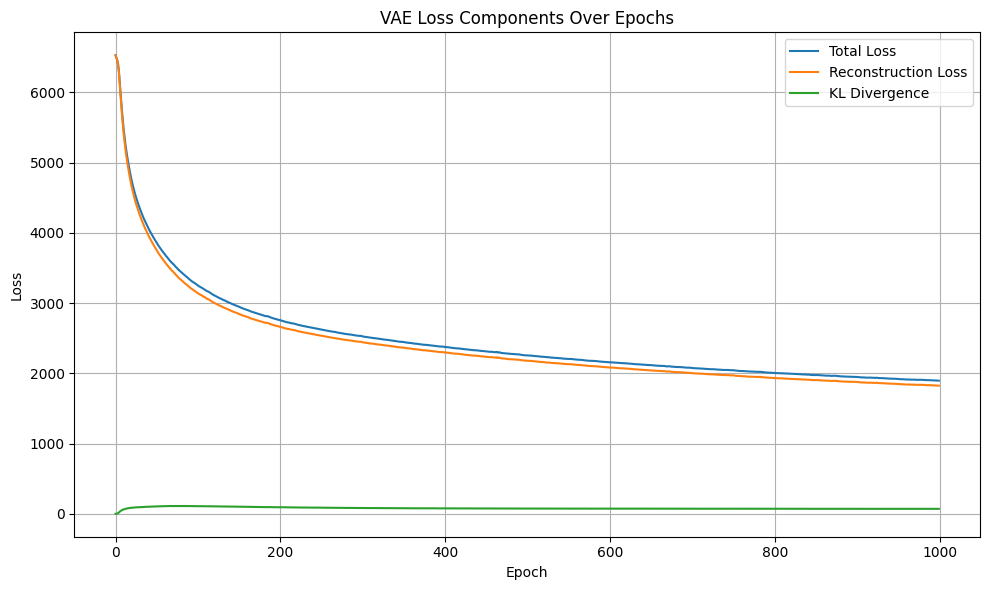

In [9]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


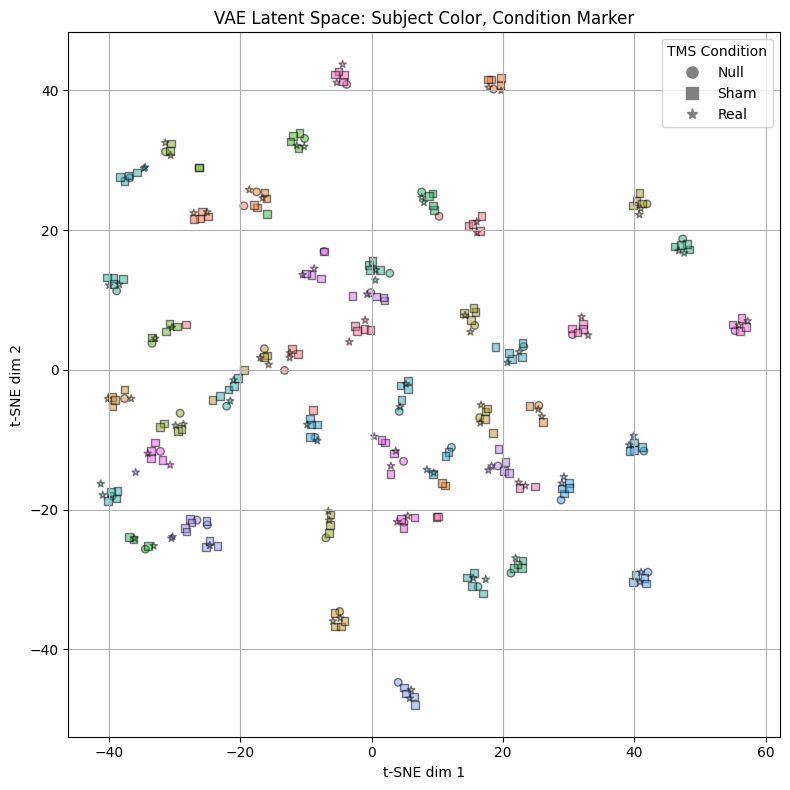

In [11]:
mu_all = get_latent_mu_cvae(model, X_tensor, subject_cond_tensor, device=DEVICE)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -1.217, p = 0.2301


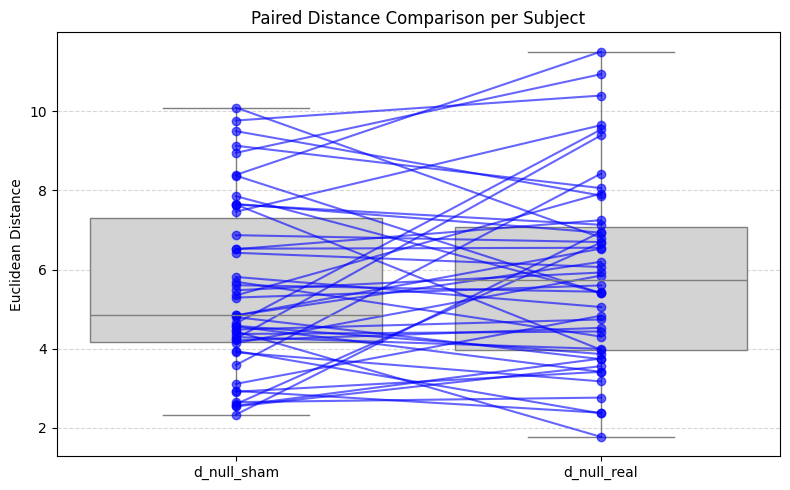

In [12]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)